In [ ]:
!apt-get -q update
!apt-get -q install -y ttf-mscorefonts-installer

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,853 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,771 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,269 kB]
Hit:13 https://ppa.launchpadconten

In [ ]:
!fc-cache -f -v

/usr/share/fonts: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/X11: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/X11/encodings: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/X11/encodings/large: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/X11/util: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/msttcorefonts: caching, new cache contents: 0 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/X11: skipping, looped directory detected
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/X11/encodi

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

# SDE

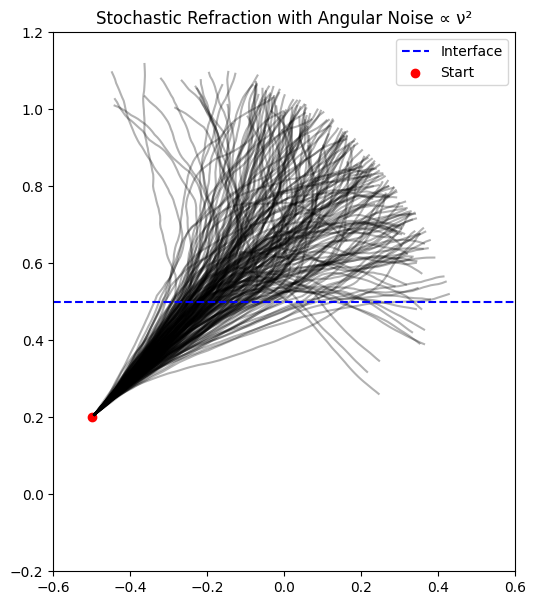

In [ ]:
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
from time import time

# Medium properties
def nu(x, y):
    # Sharp interface at y = 0.5
    return jnp.where(y < 0.5, 1.0, 10.0)  # Low to high refractive index

# Simulation parameters
ds = 0.01
num_steps = 100
D_theta = 0.05
key = random.PRNGKey(int(time()))

# Initial conditions
init_pos = jnp.array([-0.5, 0.2])  # below interface
init_angle = jnp.pi / 4  # 45 degrees incidence
num_particles = 200

@jax.jit
def simulate_particle(key, init_pos, init_angle):
    def step_fn(carry, _):
        pos, theta, key = carry
        key, subkey = random.split(key)
        nuxy = nu(pos[0], pos[1])
        dtheta = jnp.sqrt(2 * D_theta) * jnp.sqrt(nuxy * ds) * random.normal(subkey)
        theta_new = theta + dtheta
        pos_new = pos + ds * jnp.array([jnp.cos(theta_new), jnp.sin(theta_new)])

        # Return a single vector per step: [x, y, theta]
        output = jnp.array([pos_new[0], pos_new[1], theta_new])
        return (pos_new, theta_new, key), output

    (_, _, _), trajectory = jax.lax.scan(step_fn, (init_pos, init_angle, key), None, length=num_steps)
    return trajectory  # shape: (num_steps, 3)

# Run simulation for multiple particles
trajectories = jax.vmap(simulate_particle, in_axes=(0, None, None))(
    random.split(key, num_particles), init_pos, init_angle
)

# Plot
plt.figure(figsize=(7, 7))
for traj in trajectories:
    plt.plot(traj[:, 0], traj[:, 1], alpha=0.3, color='black')

# Draw interface
plt.axhline(0.5, color='blue', linestyle='--', label='Interface')
plt.scatter(*init_pos, color='red', label='Start')
plt.xlim(-0.6, 0.6)
plt.ylim(-0.2, 1.2)
plt.gca().set_aspect('equal')
plt.legend()
plt.title('Stochastic Refraction with Angular Noise ∝ ν²')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import jax.numpy as jnp

def extract_angles(traj):
    ys = traj[:, 1]
    thetas = traj[:, 2]

    crossings = (ys[:-1] < 0.5) & (ys[1:] >= 0.5)
    found = jnp.any(crossings)

    # Get index of first crossing, safely
    crossing_idx = jnp.argmax(crossings)  # returns 0 if none found
    idx = jax.lax.select(found, crossing_idx, -1)  # -1 if not found

    def valid_case(i):
        i = jnp.clip(i, 0, traj.shape[0] - 6)
        return thetas[i], thetas[i + 5]

    def invalid_case():
        return jnp.nan, jnp.nan

    return jax.lax.cond(idx >= 0, lambda _: valid_case(idx), lambda _: invalid_case(), operand=None)

theta_pairs = jax.vmap(extract_angles)(trajectories)

# Compute sin(theta)/nu
theta_in, theta_out = theta_pairs
valid = ~jnp.isnan(theta_in) & ~jnp.isnan(theta_out)

theta_in = theta_in[valid]
theta_out = theta_out[valid]

nu_in = 1.0
nu_out = 3.0

lhs = jnp.sin(theta_in) / nu_in
rhs = jnp.sin(theta_out) / nu_out

In [ ]:
df = pd.DataFrame({
    'sin(theta)/nu': np.concatenate([lhs, rhs]),
    'Region': ['Before (ν=1)'] * len(lhs) + ['After (ν=3)'] * len(rhs)
})

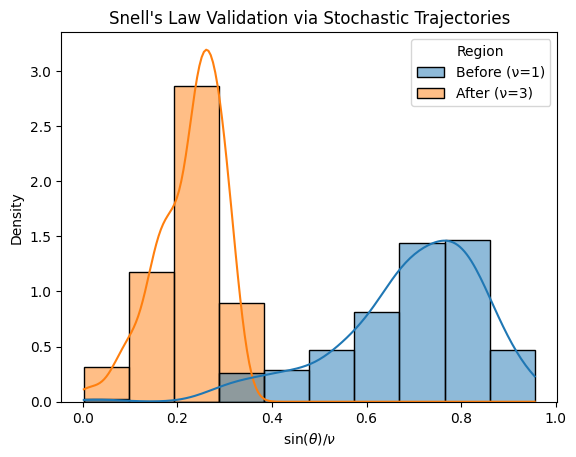

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df, x='sin(theta)/nu', hue='Region', kde=True, stat='density')
plt.title("Snell's Law Validation via Stochastic Trajectories")
plt.xlabel(r'$\sin(\theta)/\nu$')
plt.show()

# Trail following

Import

In [ ]:
import jax
from jax import lax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random
from jax import grad
from jax import vmap
from functools import partial
from time import time

Grid

In [ ]:
grid_size = 100
x = jnp.linspace(-0.5, 1.0, grid_size)
y = jnp.linspace(-0.5, 1.5, grid_size)
X, Y = jnp.meshgrid(x, y)

Trail

In [ ]:
# Trail parameters
sigma_pheromone = 0.05  # Spread of the pheromone field

In [ ]:
# Source and destination
point_a = jnp.array([0.0, 0.0])
point_b = jnp.array([0.5, 1.0])

In [ ]:
def create_squiggly_line(point_a, point_b, num_points=120, amplitude=0.1, frequency=1.0):
    t = jnp.linspace(0, 1, num_points)
    base_line = point_a + t[:, None] * (point_b - point_a)
    direction = point_b - point_a
    normal = jnp.array([-direction[1], direction[0]])  # Perpendicular vector
    normal = normal / jnp.linalg.norm(normal)  # Normalize
    squiggle = amplitude * jnp.sin(frequency * t * 2 * jnp.pi)  # Sinusoidal squiggle
    squiggly_line = base_line + squiggle[:, None] * normal
    return squiggly_line

# Define the Gaussian kernel for diffusion
def gaussian_kernel(x, y, sigma=sigma_pheromone):
    return jnp.exp(-(x**2 + y**2) / (2 * sigma**2))

vmap_gaussian_kernel = jax.vmap(gaussian_kernel, in_axes=(0, 0, None))

Gradient of pheromone field using automatic differentiation

In [ ]:
max_pheromone = 19.5

In [ ]:
def compute_pheromone_gradient(trajectory_points, x, y):
    def eval_pheromone(x_pos, y_pos):
        dx = x_pos - trajectory_points[:, 0]
        dy = y_pos - trajectory_points[:, 1]
        pheromone_values = vmap_gaussian_kernel(dx, dy, sigma_pheromone)
        # return jnp.minimum(jnp.sum(pheromone_values), max_pheromone)
        return jnp.log(0.001+jnp.sum(pheromone_values))

    grad_x = grad(lambda x: eval_pheromone(x, y))(x)
    grad_y = grad(lambda y: eval_pheromone(x, y))(y)
    return jnp.array([grad_x, grad_y])

Agent dynamics

In [ ]:
# Agent parameters
speed = 1.0  # Linear speed of the agent

epsilon = 1.0

# beta_over_sigma = 0.8
# beta = 1.0/epsilon # Trail affinity
# angular_noise_std = 5.0/(beta_over_sigma*epsilon**(0.5))  # Standard deviation of angular noise

beta_nom = 10.0
angular_noise_std = 1.0

In [ ]:
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

def nu(x, y):
    k = 25.0  # Controls the steepness of the sigmoid
    return 1 + 0.5*sigmoid(k * (y - 0.5))

def grad_ln_nu(x, y):
    k = 25.0  # Should be the same as in nu function
    return k * sigmoid(k * (y - 0.5)) * (1 - sigmoid(k * (y - 0.5))) / nu(x, y)

def update_agent_state(state, trajectory_points, beta, angular_noise_std, key):
    x, y, theta = state
    grad_x, grad_y = compute_pheromone_gradient(trajectory_points, x, y)

    tangent_vector = jnp.array([jnp.cos(theta), jnp.sin(theta)])
    normal_vector = jnp.array([-jnp.sin(theta), jnp.cos(theta)])
    angular_velocity = beta * jnp.dot(jnp.array([grad_x, grad_y]), normal_vector)

    key, subkey = random.split(key)
    angular_velocity += angular_noise_std * random.normal(subkey)

    theta += angular_velocity * dt
    # x += (1/nu(x, y)) * jnp.cos(theta) * dt
    # y += (1/nu(x, y)) * jnp.sin(theta) * dt

    x += jnp.cos(theta) * dt
    y += jnp.sin(theta) * dt

    return jnp.array([x, y, theta]), key

Simulation

In [ ]:
# Simulation parameters
dt = 0.01  # Time step
num_steps = 160 # Number of simulation steps

In [ ]:
# Initialize the agent
def initialize_agent(key):
    key, subkey = random.split(key)
    initial_position = random.normal(subkey, (2,)) * 0.01  # Gaussian around (0, 0)
    initial_theta = jnp.arctan2(point_b[1] - point_a[1], point_b[0] - point_a[0])  # Pointing towards (0.5, 1)
    # initial_theta = jnp.arctan2(0.0 - point_a[1], point_b[0] - point_a[0])
    return jnp.array([initial_position[0], initial_position[1], initial_theta]), key

# def simulate_agent(trajectory_points, num_steps, angular_noise_std, key):
#     initial_state, key = initialize_agent(key)

#     def body_fun(carry, _):
#         state, key = carry
#         new_state, new_key = update_agent_state(state, trajectory_points, angular_noise_std, key)
#         return (new_state, new_key), new_state[:2]

#     (_, _), trajectory = lax.scan(body_fun, (initial_state, key), jnp.arange(num_steps))

#     trajectory = jnp.vstack([initial_state[:2][None, :], trajectory])

#     return trajectory

def simulate_agent(trajectory_points, num_steps, beta, angular_noise_std, key):
    initial_state, key = initialize_agent(key)

    def body_fun(carry, _):
        state, key = carry
        new_state, new_key = update_agent_state(state, trajectory_points, beta, angular_noise_std, key)
        return (new_state, new_key), new_state[:2]

    (_, _), trajectory = lax.scan(body_fun, (initial_state, key), jnp.arange(num_steps))
    trajectory = jnp.vstack([initial_state[:2][None, :], trajectory])  # (num_steps + 1, 2)

    # Compute distances to point_b
    dists = jnp.linalg.norm(trajectory - point_b, axis=1)
    close_enough = dists < 0.01

    # Get all possible indices: [0, 1, 2, ..., T]
    idxs = jnp.arange(trajectory.shape[0])
    # Masked indices: large where false, idx where true
    masked_idxs = jnp.where(close_enough, idxs, trajectory.shape[0])
    # Get first valid index (or length+1 if not found)
    first_idx = jnp.min(masked_idxs)

    # Create mask for valid entries
    mask = idxs <= first_idx

    # Pad with final point if shorter
    last_valid = trajectory[jnp.minimum(first_idx, trajectory.shape[0] - 1)]
    padded = jnp.where(mask[:, None], trajectory, last_valid)

    return padded

In [ ]:
trajectory = simulate_agent(create_squiggly_line(point_a, point_b), num_steps, beta_nom, angular_noise_std, random.PRNGKey(int(time())))

In [ ]:
def create_pheromone_trail_from_trajectory(trajectory, X, Y, sigma=sigma_pheromone):
    pheromone_field = jnp.zeros_like(X)
    for p in trajectory:
        pheromone_field += gaussian_kernel(X - p[0], Y - p[1], sigma)
    return pheromone_field

Plot pheromone field and agent trajectory

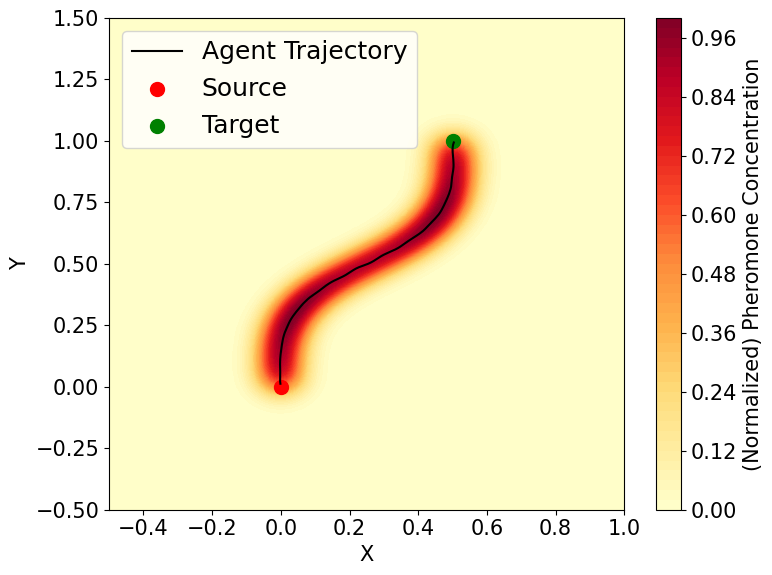

In [ ]:
import matplotlib.font_manager as fm

# Set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 15  # Base font size

plt.figure(figsize=(8, 6))
pheromone_field = create_pheromone_trail_from_trajectory(create_squiggly_line(point_a, point_b), X, Y)
pheromone_field = pheromone_field/jnp.max(pheromone_field)
plt.contourf(X, Y, pheromone_field, levels=50, cmap='YlOrRd')
colorbar = plt.colorbar(label='(Normalized) Pheromone Concentration')
# colorbar.ax.yaxis.label.set_fontfamily('Times New Roman')
plt.plot(trajectory[:, 0], trajectory[:, 1], color='black', label='Agent Trajectory')
plt.scatter(point_a[0], point_a[1], s=100, color='red', label='Source')
plt.scatter(point_b[0], point_b[1], s=100, color='green', label='Target')
plt.xlabel('X')
plt.ylabel('Y')

# Create legend with increased font size
legend = plt.legend(fontsize=18)  # Increase font size to 14 (or any size you prefer)

# Ensure all text elements use Times New Roman
for text in plt.gca().findobj(match=lambda x: isinstance(x, plt.Text)):
    text.set_fontfamily('Times New Roman')

# Set legend font to Times New Roman (in case it wasn't caught by the loop above)
for text in legend.get_texts():
    text.set_fontfamily('Times New Roman')

plt.tight_layout()
plt.savefig('trail_following_simulation.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

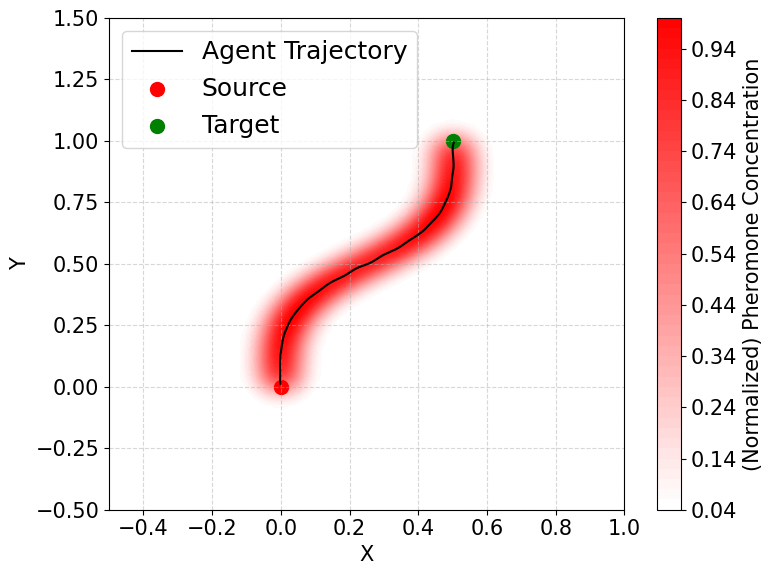

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

# === Threshold value for visibility ===
threshold = 0.05  # Below this, map everything to white

# === Create white-to-red custom colormap ===
white_to_red = mcolors.LinearSegmentedColormap.from_list('white_red', ['white', 'red'])

# === Normalize pheromone field ===
raw_field = create_pheromone_trail_from_trajectory(
    create_squiggly_line(point_a, point_b), X, Y
)
pheromone_field = raw_field / jnp.max(raw_field)

# === Mask or clip values below threshold ===
masked_field = jnp.clip(pheromone_field, threshold, 1.0)

# === Normalize to [threshold, 1.0] range ===
norm = mcolors.Normalize(vmin=threshold, vmax=1.0)

# === Set font ===
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 15

# === Plot ===
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, masked_field, levels=50, cmap=white_to_red, norm=norm)
colorbar = plt.colorbar(contour, label='(Normalized) Pheromone Concentration')

plt.plot(trajectory[:, 0], trajectory[:, 1], color='black', label='Agent Trajectory')
plt.scatter(point_a[0], point_a[1], s=100, color='red', label='Source')
plt.scatter(point_b[0], point_b[1], s=100, color='green', label='Target')

plt.xlabel('X')
plt.ylabel('Y')

# Legend styling
legend = plt.legend(fontsize=18)
for text in legend.get_texts():
    text.set_fontfamily('Times New Roman')

# Ensure all plot text uses Times New Roman
for text in plt.gca().findobj(match=lambda x: isinstance(x, plt.Text)):
    text.set_fontfamily('Times New Roman')

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('trail_following_white_to_red.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

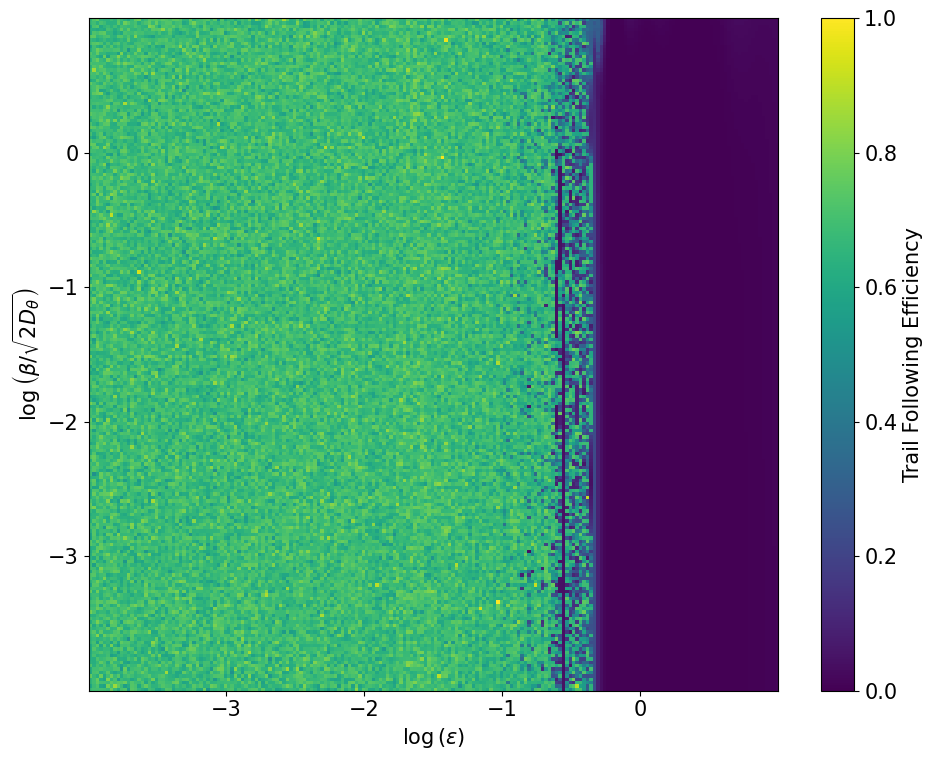

In [ ]:
# def evaluate_trail_following(epsilon, beta_over_sigma, num_steps=125):
#     speed = 1.0
#     beta = 1.0 / epsilon
#     angular_noise_std = 1.0 / (beta_over_sigma * epsilon**0.5)

#     # Create initial pheromone trail
#     pheromone_field = create_pheromone_trail_from_trajectory(create_squiggly_line(point_a, point_b), X, Y)
#     pheromone_field = pheromone_field/jnp.max(pheromone_field)

#     # Simulate agent
#     key = random.PRNGKey(0)
#     trajectory = simulate_agent(create_squiggly_line(point_a, point_b), num_steps, angular_noise_std, random.PRNGKey(0))

#     def get_pheromone_value(pos):
#         x_idx = jnp.argmin(jnp.abs(x - pos[0]))
#         y_idx = jnp.argmin(jnp.abs(y - pos[1]))
#         return pheromone_field[y_idx, x_idx]

#     pheromone_values = jax.vmap(get_pheromone_value)(trajectory)

#     return jnp.sum(pheromone_values)


# def evaluate_trail_following_area(epsilon, beta_over_sigma, num_steps=125):
#     speed = 1.0
#     beta = 1.0 / epsilon
#     angular_noise_std = 1.0 / (beta_over_sigma * epsilon**0.5)

#     # Create trail
#     trail = create_squiggly_line(point_a, point_b, num_points=num_steps+1)

#     # Simulate agent
#     key = random.PRNGKey(0)
#     trajectory = simulate_agent(trail, num_steps, angular_noise_std, key)

#     # Ensure both have same shape
#     min_len = min(trail.shape[0], trajectory.shape[0])
#     trail = trail[:min_len]
#     trajectory = trajectory[:min_len]

#     # Approximate area = integrated L2 norm of deviation
#     distances = jnp.linalg.norm(trail - trajectory, axis=1)
#     area_approx = jnp.sum(distances) * dt  # Treat dt as arc-length step approx

#     return area_approx


def evaluate_trail_following_area(epsilon, Dtheta, num_steps=125):
    speed = 1.0
    beta = beta_nom / epsilon
    angular_noise_std = (2*Dtheta/epsilon)**0.5

    # Create trail
    trail = create_squiggly_line(point_a, point_b, num_points=num_steps+1)

    # Simulate agent
    key = random.PRNGKey(0)
    trajectory = simulate_agent(trail, num_steps, beta, angular_noise_std, key)

    # Ensure both have same shape
    min_len = min(trail.shape[0], trajectory.shape[0])
    trail = trail[:min_len]
    trajectory = trajectory[:min_len]

    # Approximate area = integrated L2 norm of deviation
    distances = jnp.linalg.norm(trail - trajectory, axis=1)
    area_approx = jnp.sum(distances) * dt  # Treat dt as arc-length step approx

    return area_approx


# Define parameter ranges
epsilon_range = jnp.logspace(-4, 1, 200)
Dtheta_range = jnp.logspace(-4, 1, 200)

# Create parameter grid
epsilon_grid, Dtheta_grid = jnp.meshgrid(epsilon_range, Dtheta_range)

# Vectorize the evaluation function
vectorized_evaluate = jnp.vectorize(evaluate_trail_following_area, signature='(),()->()')

# Perform parameter sweep
efficiency_grid = vectorized_evaluate(epsilon_grid, Dtheta_grid)
efficiency_grid_normalized = (efficiency_grid - efficiency_grid.min()) / (efficiency_grid.max() - efficiency_grid.min())

# Plot heatmap
plt.figure(figsize=(10, 8))
plt.imshow(efficiency_grid_normalized, extent=[jnp.log10(epsilon_range.min()), jnp.log10(epsilon_range.max()),
                                    jnp.log10(Dtheta_range.min()), jnp.log10(Dtheta_range.max())],
           aspect='auto', origin='lower', cmap='viridis')

plt.colorbar(label='Trail Following Efficiency')
plt.xlabel(r'$\log \left(\epsilon \right)$')
plt.ylabel(r'$\log \left(\beta/\sqrt{2D_{\theta}} \right)$')
# plt.title('Trail Following Efficiency')

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

# Increase legend font size
# plt.legend(fontsize=18)

# Ensure all text elements use Times New Roman
for text in plt.gca().findobj(match=lambda x: isinstance(x, plt.Text)):
    text.set_fontfamily('Times New Roman')

plt.tight_layout()
plt.savefig('trail_following_efficiency_heatmap.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random
import matplotlib

# === Constants and Setup ===
dt = 0.01
point_a = jnp.array([0.0, 0.0])
point_b = jnp.array([0.5, 1.0])
sigma_pheromone = 0.05

# === Trail ===
def create_squiggly_line(point_a, point_b, num_points=120, amplitude=0.1, frequency=1.0):
    t = jnp.linspace(0, 1, num_points)
    base_line = point_a + t[:, None] * (point_b - point_a)
    direction = point_b - point_a
    normal = jnp.array([-direction[1], direction[0]])
    normal = normal / jnp.linalg.norm(normal)
    squiggle = amplitude * jnp.sin(frequency * t * 2 * jnp.pi)
    squiggly_line = base_line + squiggle[:, None] * normal
    return squiggly_line

# === Gaussian kernel ===
def gaussian_kernel(x, y, sigma=sigma_pheromone):
    return jnp.exp(-(x**2 + y**2) / (2 * sigma**2))

vmap_gaussian_kernel = jax.vmap(gaussian_kernel, in_axes=(0, 0, None))

# === Pheromone gradient ===
def compute_pheromone_gradient(trajectory_points, x, y):
    def eval_pheromone(x_pos, y_pos):
        dx = x_pos - trajectory_points[:, 0]
        dy = y_pos - trajectory_points[:, 1]
        pheromone_values = vmap_gaussian_kernel(dx, dy, sigma_pheromone)
        return jnp.log(0.001 + jnp.sum(pheromone_values))
    grad_x = jax.grad(lambda x: eval_pheromone(x, y))(x)
    grad_y = jax.grad(lambda y: eval_pheromone(x, y))(y)
    return jnp.array([grad_x, grad_y])

# === Medium and dynamics ===
def sigmoid(x): return 1 / (1 + jnp.exp(-x))
def nu(x, y): return 1 + 0.5 * sigmoid(25.0 * (y - 0.5))

def update_agent_state(state, trajectory_points, beta, angular_noise_std, key):
    x, y, theta = state
    grad_x, grad_y = compute_pheromone_gradient(trajectory_points, x, y)
    tangent = jnp.array([jnp.cos(theta), jnp.sin(theta)])
    normal = jnp.array([-jnp.sin(theta), jnp.cos(theta)])
    omega = beta * jnp.dot(jnp.array([grad_x, grad_y]), normal)

    key, subkey = random.split(key)
    omega += angular_noise_std * random.normal(subkey)

    theta += omega * dt
    x += jnp.cos(theta) * dt
    y += jnp.sin(theta) * dt
    return jnp.array([x, y, theta]), key

# === Agent initialization ===
def initialize_agent(key):
    key, subkey = random.split(key)
    pos = random.normal(subkey, (2,)) * 0.01
    theta = jnp.arctan2(point_b[1] - point_a[1], point_b[0] - point_a[0])
    return jnp.array([pos[0], pos[1], theta]), key

# === Simulate agent trajectory ===
def simulate_agent(trail_points, num_steps, beta, angular_noise_std, key):
    state, key = initialize_agent(key)
    def body(carry, _):
        state, key = carry
        new_state, key = update_agent_state(state, trail_points, beta, angular_noise_std, key)
        return (new_state, key), new_state[:2]
    (_, _), traj = jax.lax.scan(body, (state, key), jnp.arange(num_steps))
    traj = jnp.vstack([state[:2][None, :], traj])
    return traj

# === Area between trajectory and trail ===
def evaluate_trail_following_area(epsilon, Dtheta, num_steps=125, key=None):
    beta = beta_nom / epsilon
    angular_noise_std = (2 * Dtheta / epsilon)**0.5
    trail = create_squiggly_line(point_a, point_b, num_points=num_steps+1)
    if key is None:
        key = random.PRNGKey(0)
    traj = simulate_agent(trail, num_steps, beta, angular_noise_std, key)
    N = min(trail.shape[0], traj.shape[0])
    dist = jnp.linalg.norm(trail[:N] - traj[:N], axis=1)
    area_approx = jnp.sum(dist) * dt
    return area_approx

# === Evaluation parameters ===
epsilon_fixed = 1.0
num_trials = 10
num_steps = 125
Dtheta_vals = jnp.logspace(-2, 2, 100)
log_bos = jnp.log10(Dtheta_vals)

# === Run trials ===
def single_trial(Dtheta, key):
    return evaluate_trail_following_area(epsilon_fixed, Dtheta, num_steps=num_steps, key=key)

def repeated_trials(Dtheta, master_key):
    trial_keys = random.split(master_key, num_trials)
    return jax.vmap(lambda k: single_trial(Dtheta, k))(trial_keys)

master_keys = random.split(random.PRNGKey(42), len(Dtheta_vals))
all_areas = jnp.stack([repeated_trials(bos, key) for bos, key in zip(Dtheta_vals, master_keys)])  # shape: (len(beta), num_trials)

# === Statistics ===
mean_area = jnp.mean(all_areas, axis=1)
std_area = jnp.std(all_areas, axis=1)
ci_upper = mean_area + 1.96 * std_area / jnp.sqrt(num_trials)
ci_lower = mean_area - 1.96 * std_area / jnp.sqrt(num_trials)

# === Plot ===
plt.figure(figsize=(9, 6))
plt.plot(log_bos, mean_area, color='black', label='Mean Area')
plt.fill_between(log_bos, ci_lower, ci_upper, color='gray', alpha=0.4, label='95% CI')
plt.xlabel(r'$\log_{10} \left( \beta / \sqrt{2D_\theta} \right)$')
plt.ylabel('Area Between Trail and Trajectory')
plt.title(f'Trail Following Deviation with Confidence Bounds (ε = {epsilon_fixed})')

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
for text in plt.gca().findobj(match=lambda x: isinstance(x, plt.Text)):
    text.set_fontfamily('Times New Roman')

plt.legend()
plt.tight_layout()
plt.savefig('area_vs_beta_confidence.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

KeyboardInterrupt: 

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random
import matplotlib

# === Constants ===
dt = 0.01
point_a = jnp.array([0.0, 0.0])
point_b = jnp.array([0.5, 1.0])
sigma_pheromone = 0.05
num_steps = 125
num_trials = 10
epsilon_vals = [0.01, 0.1, 1.0]
colors = ['tab:blue', 'tab:green', 'tab:red']
labels = [r'$\epsilon=0.01$', r'$\epsilon=0.1$', r'$\epsilon=1.0$']
Dtheta_vals = jnp.logspace(-2, 2, 50)

# === Trail and dynamics ===
def create_squiggly_line(point_a, point_b, num_points=120, amplitude=0.1, frequency=1.0):
    t = jnp.linspace(0, 1, num_points)
    base = point_a + t[:, None] * (point_b - point_a)
    dir_vec = point_b - point_a
    normal = jnp.array([-dir_vec[1], dir_vec[0]]) / jnp.linalg.norm(dir_vec)
    squiggle = amplitude * jnp.sin(frequency * t * 2 * jnp.pi)
    return base + squiggle[:, None] * normal

def gaussian_kernel(x, y, sigma=sigma_pheromone):
    return jnp.exp(-(x**2 + y**2) / (2 * sigma**2))

vmap_kernel = jax.vmap(gaussian_kernel, in_axes=(0, 0, None))

def compute_pheromone_gradient(points, x, y):
    def eval_pheromone(xp, yp):
        dx = xp - points[:, 0]
        dy = yp - points[:, 1]
        return jnp.log(0.001 + jnp.sum(vmap_kernel(dx, dy, sigma_pheromone)))
    return jnp.array([jax.grad(lambda x: eval_pheromone(x, y))(x),
                      jax.grad(lambda y: eval_pheromone(x, y))(y)])

def sigmoid(x): return 1 / (1 + jnp.exp(-x))
def nu(x, y): return 1 + 0.5 * sigmoid(25.0 * (y - 0.5))

def update_agent_state(state, trail, angular_noise_std, beta, key):
    x, y, theta = state
    grad_x, grad_y = compute_pheromone_gradient(trail, x, y)
    tangent = jnp.array([jnp.cos(theta), jnp.sin(theta)])
    normal = jnp.array([-jnp.sin(theta), jnp.cos(theta)])
    omega = beta * jnp.dot(jnp.array([grad_x, grad_y]), normal)
    key, subkey = random.split(key)
    omega += angular_noise_std * random.normal(subkey)
    theta += omega * dt
    x += jnp.cos(theta) * dt
    y += jnp.sin(theta) * dt
    return jnp.array([x, y, theta]), key

def initialize_agent(key):
    key, subkey = random.split(key)
    pos = random.normal(subkey, (2,)) * 0.01
    theta = jnp.arctan2(point_b[1] - point_a[1], point_b[0] - point_a[0])
    return jnp.array([pos[0], pos[1], theta]), key

def simulate_agent(trail, num_steps, angular_noise_std, beta, key):
    state, key = initialize_agent(key)
    def body(carry, _):
        state, key = carry
        new_state, key = update_agent_state(state, trail, angular_noise_std, beta, key)
        return (new_state, key), new_state[:2]
    (_, _), traj = jax.lax.scan(body, (state, key), jnp.arange(num_steps))
    return jnp.vstack([state[:2][None, :], traj])

def arc_length_parametrize(curve, num_points=200):
    # Compute cumulative arc length
    deltas = jnp.linalg.norm(jnp.diff(curve, axis=0), axis=1)
    s = jnp.concatenate([jnp.array([0.0]), jnp.cumsum(deltas)])
    s /= s[-1]  # Normalize to [0, 1]

    # Interpolation points
    s_uniform = jnp.linspace(0.0, 1.0, num_points)

    # Linear interpolation along arc length
    def interp_axis(axis):
        return jnp.interp(s_uniform, s, curve[:, axis])

    return jnp.stack([interp_axis(0), interp_axis(1)], axis=1)  # (num_points, 2)

def evaluate_area(epsilon, Dtheta, key, num_steps=125):
    beta = beta_nom / epsilon
    angular_noise_std = (2 * Dtheta / epsilon)**0.5

    # Generate and simulate
    trail = create_squiggly_line(point_a, point_b, num_points=num_steps+1)
    traj = simulate_agent(trail, num_steps, angular_noise_std, beta, key)

    # Arc length reparameterize both to same number of samples
    trail_arc = arc_length_parametrize(trail, num_points=200)
    traj_arc = arc_length_parametrize(traj, num_points=200)

    # L2 deviation integrated over arc length domain [0,1]
    deviation = jnp.linalg.norm(traj_arc - trail_arc, axis=1)
    area_approx = jnp.mean(deviation)  # ∫ ||x_traj(s) - x_trail(s)|| ds ≈ avg over s

    return area_approx

# === Evaluation loop ===
def run_trials(epsilon):
    master_keys = random.split(random.PRNGKey(int(1e6 * epsilon)), len(Dtheta_vals))
    all_areas = []
    for i, bos in enumerate(Dtheta_vals):
        keys = random.split(master_keys[i], num_trials)
        areas = jax.vmap(lambda k: evaluate_area(epsilon, bos, k))(keys)
        all_areas.append(areas)
    return jnp.stack(all_areas)

In [ ]:
# === Plotting ===
plt.figure(figsize=(9, 6))
for eps, color, label in zip(epsilon_vals, colors, labels):
    data = run_trials(eps)
    mean = jnp.mean(data, axis=1)
    std = jnp.std(data, axis=1)
    ci = 1.96 * std / jnp.sqrt(num_trials)
    plt.plot(Dtheta_vals, mean, label=label, color=color)
    plt.fill_between(Dtheta_vals, mean - ci, mean + ci, color=color, alpha=0.3)

plt.xscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel(r'$\beta / D_\theta$', fontsize=18)
# plt.ylabel('Path Deviation', fontsize=18)
plt.ylabel(r'Path Deviation $=\int_0^1 \| \mathbf{x}_{\text{agent}}(s) - \mathbf{x}_{\text{trail}}(s) \| \, ds$', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('trail_following_path_deviation.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
beta_over_sigma_values = [0.1, 1.0, 10.0]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# === Setup ===
beta_over_sigma_values = [0.01, 0.1, 1.0, 10.0]
colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:purple']
labels = [rf'$\beta/\sqrt{{2D_\theta}} = {val}$' for val in beta_over_sigma_values]
epsilon = 0.1
beta = 1.0 / epsilon

# === Pheromone Field ===
trail = create_squiggly_line(point_a, point_b)
pheromone_field = create_pheromone_trail_from_trajectory(trail, X, Y)
pheromone_field = pheromone_field / jnp.max(pheromone_field)

# === Colormap: white → red ===
white_to_red = mcolors.LinearSegmentedColormap.from_list('white_red', ['white', 'orange'])
norm = mcolors.Normalize(vmin=0.05, vmax=1.0)
masked_field = jnp.clip(pheromone_field, 0.05, 1.0)

# === Plot ===
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, masked_field, levels=50, cmap=white_to_red, norm=norm)
plt.colorbar(label='(Normalized) Pheromone Concentration')

# === Simulate and plot representative trajectories ===
for bos, color, label in zip(beta_over_sigma_values, colors, labels):
    angular_noise_std = 1.0 / (bos * epsilon**0.5)
    traj = simulate_agent(trail, num_steps=125, angular_noise_std=angular_noise_std, beta=beta, key=random.PRNGKey(int(1e6 * bos)))
    plt.plot(traj[:, 0], traj[:, 1], label=label, color=color)

# === Decorations ===
plt.scatter(point_a[0], point_a[1], s=100, color='red', label='Source')
plt.scatter(point_b[0], point_b[1], s=100, color='green', label='Target')
plt.xlabel('X')
plt.ylabel('Y')

plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('representative_traj_vs_beta_over_sigma.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Corrected trail following eval

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random, jit, vmap

# === Constants ===
dt = 0.0001
point_a = jnp.array([0.0, 0.0])
point_b = jnp.array([0.5, 1.0])
sigma_pheromone = 0.05
num_steps = 14000
num_trials = 10
epsilon_vals = [1.0]
colors = ['tab:orange', 'tab:green', 'tab:red']
# labels = [r'$\epsilon=0.1$', r'$\epsilon=1.0$', r'$\epsilon=10.0$']
Dtheta_vals = jnp.logspace(-3, 3, 60)
l0 = float(jnp.linalg.norm(point_b - point_a))
beta_nom = 1.0

# === Trail and dynamics ===
def create_squiggly_line(point_a, point_b, num_points=120, amplitude=0.1, frequency=1.0):
    t = jnp.linspace(0, 1, num_points)
    base = point_a + t[:, None] * (point_b - point_a)
    dir_vec = point_b - point_a
    normal = jnp.array([-dir_vec[1], dir_vec[0]]) / jnp.linalg.norm(dir_vec)
    squiggle = amplitude * jnp.sin(frequency * t * 2 * jnp.pi)
    return base + squiggle[:, None] * normal

def gaussian_kernel(x, y, sigma):
    return jnp.exp(-(x**2 + y**2) / (2 * sigma**2))

vmap_kernel = jax.vmap(gaussian_kernel, in_axes=(0, 0, None))

@jit
def compute_pheromone_gradient(points, x, y):
    dx = x - points[:, 0]
    dy = y - points[:, 1]
    distances = vmap_kernel(dx, dy, sigma_pheromone)
    f = jnp.log(0.001 + jnp.sum(distances))
    grad_x = jax.grad(lambda x: jnp.log(0.001 + jnp.sum(vmap_kernel(x - points[:, 0], y - points[:, 1], sigma_pheromone))))(x)
    grad_y = jax.grad(lambda y: jnp.log(0.001 + jnp.sum(vmap_kernel(x - points[:, 0], y - points[:, 1], sigma_pheromone))))(y)
    return jnp.array([grad_x, grad_y])

@jit
def update_agent_state(state, trail, angular_noise_std, beta, key):
    x, y, theta = state
    grad = compute_pheromone_gradient(trail, x, y)
    tangent = jnp.array([jnp.cos(theta), jnp.sin(theta)])
    normal = jnp.array([-tangent[1], tangent[0]])
    omega = beta * jnp.dot(grad, normal)
    key, subkey = random.split(key)
    theta += omega * dt + angular_noise_std * (dt**0.5) * random.normal(subkey)
    x += jnp.cos(theta) * dt
    y += jnp.sin(theta) * dt
    return jnp.array([x, y, theta]), key

@jit
def simulate_agent(trail, angular_noise_std, beta, key, scan_steps):
    key, subkey = random.split(key)
    pos = random.normal(subkey, (2,)) * 0.01
    theta = jnp.arctan2(point_b[1] - point_a[1], point_b[0] - point_a[0])
    state = jnp.array([pos[0], pos[1], theta])
    def body(carry, _):
        state, key = carry
        state, key = update_agent_state(state, trail, angular_noise_std, beta, key)
        return (state, key), state[:2]
    (_, _), traj = jax.lax.scan(body, (state, key), scan_steps)
    return traj

@jit
def arc_length_parametrize(curve, num_points=200):
    deltas = jnp.linalg.norm(jnp.diff(curve, axis=0), axis=1)
    s = jnp.concatenate([jnp.array([0.0]), jnp.cumsum(deltas)])
    s /= s[-1]
    s_uniform = jnp.linspace(0.0, 1.0, num_points)
    def interp_axis(axis): return jnp.interp(s_uniform, s, curve[:, axis])
    return jnp.stack([interp_axis(0), interp_axis(1)], axis=1)

@jit
def evaluate_area(epsilon, Dtheta, key):
    beta = beta_nom / epsilon
    angular_noise_std = jnp.sqrt(2 * Dtheta / epsilon)
    trail = create_squiggly_line(point_a, point_b, num_points=num_steps+1)
    scan_steps = jnp.arange(num_steps)
    traj = simulate_agent(trail, angular_noise_std, beta, key, scan_steps)
    trail_arc = arc_length_parametrize(trail)
    traj_arc = arc_length_parametrize(traj)
    deviation = jnp.linalg.norm(traj_arc - trail_arc, axis=1)
    return jnp.mean(deviation)

# @jit
# def evaluate_area(epsilon, Dtheta, key):
#     beta = beta_nom / epsilon
#     angular_noise_std = jnp.sqrt(2 * Dtheta / epsilon)
#     trail = create_squiggly_line(point_a, point_b, num_points=num_steps+1)
#     scan_steps = jnp.arange(num_steps)
#     traj = simulate_agent(trail, angular_noise_std, beta, key, scan_steps)

#     # Reparameterize both to uniform arc-length sampling
#     traj_arc = arc_length_parametrize(traj)
#     trail_arc = arc_length_parametrize(trail)

#     # Compute min distance from each trajectory point to trail points
#     def point_to_trail_distance(p):
#         dists = jnp.linalg.norm(trail_arc - p, axis=1)
#         return jnp.min(dists)

#     # Vectorize over all trajectory points
#     closest_dists = jax.vmap(point_to_trail_distance)(traj_arc)

#     return jnp.mean(closest_dists)

@jit
def evaluate_single_Dtheta(epsilon, Dtheta, trial_keys):
    area_fn = lambda k: evaluate_area(epsilon, Dtheta, k)
    return jax.vmap(area_fn)(trial_keys)

def run_trials(epsilon):
    beta_over_Dtheta_vals = beta_nom / (l0 * Dtheta_vals)
    key = random.PRNGKey(int(1e6 * epsilon))
    keys = random.split(key, len(Dtheta_vals) * num_trials).reshape(len(Dtheta_vals), num_trials, 2)
    batched_eval = jax.vmap(lambda Dtheta, ks: evaluate_single_Dtheta(epsilon, Dtheta, ks),
                            in_axes=(0, 0))
    results = batched_eval(Dtheta_vals, keys)
    return results, beta_over_Dtheta_vals

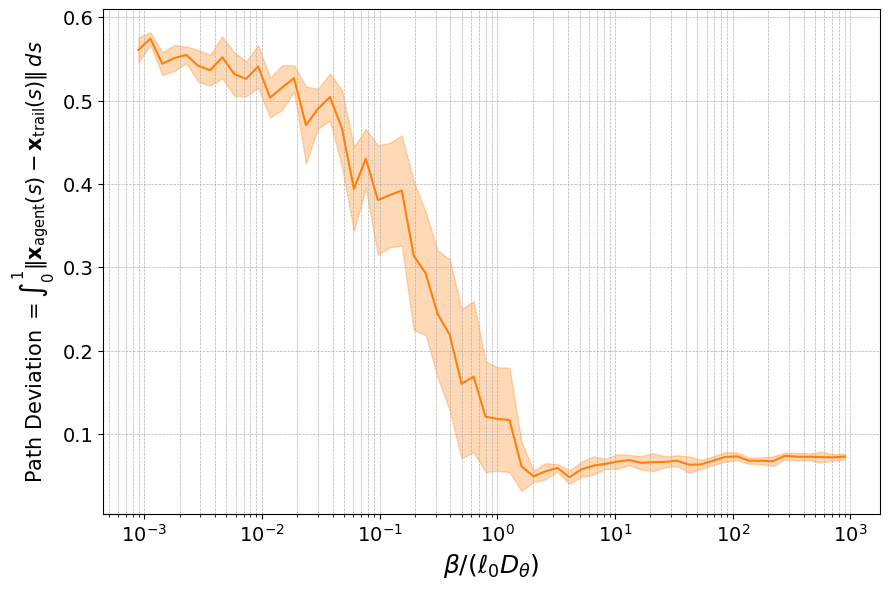

In [ ]:
# === Plotting ===
plt.figure(figsize=(9, 6))
for eps, color, label in zip(epsilon_vals, colors, labels):
    data, beta_over_Dtheta_vals = run_trials(eps)
    mean = jnp.mean(data, axis=1)
    std = jnp.std(data, axis=1)
    ci = 1.96 * std / jnp.sqrt(num_trials)
    plt.plot(beta_over_Dtheta_vals, mean, label=label, color=color)
    plt.fill_between(beta_over_Dtheta_vals, mean - ci, mean + ci, color=color, alpha=0.3)

plt.xscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel(r'$\beta / (\ell_0 D_\theta)$', fontsize=18)
plt.ylabel(r'Path Deviation $=\int_0^1 \| \mathbf{x}_{\text{agent}}(s) - \mathbf{x}_{\text{trail}}(s) \| \, ds$', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('trail_following_path_deviation_vs_beta_over_Dtheta.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

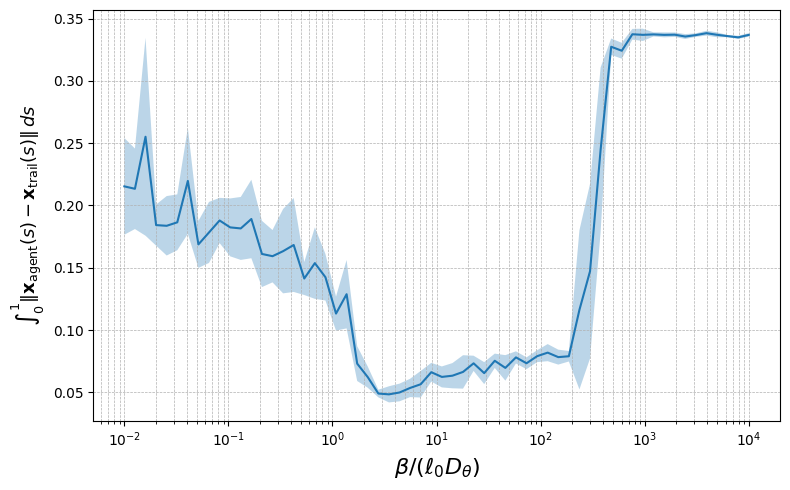

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random, jit, vmap
import numpy as np

# === Constants ===
dt = 0.0001
point_a = jnp.array([0.0, 0.0])
point_b = jnp.array([0.5, 1.0])
sigma_pheromone = 0.05
num_steps = 14000
num_trials = 10
epsilon = 1.0
Dtheta_base = 0.1
beta_over_l0Dtheta_vals = jnp.logspace(-2, 4, 60)
l0 = float(jnp.linalg.norm(point_b - point_a))
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']

# === Trail and dynamics ===
def create_squiggly_line(point_a, point_b, num_points=120, amplitude=0.1, frequency=1.0):
    t = jnp.linspace(0, 1, num_points)
    base = point_a + t[:, None] * (point_b - point_a)
    dir_vec = point_b - point_a
    normal = jnp.array([-dir_vec[1], dir_vec[0]]) / jnp.linalg.norm(dir_vec)
    squiggle = amplitude * jnp.sin(frequency * t * 2 * jnp.pi)
    return base + squiggle[:, None] * normal

def gaussian_kernel(x, y, sigma):
    return jnp.exp(-(x**2 + y**2) / (2 * sigma**2))

vmap_kernel = jax.vmap(gaussian_kernel, in_axes=(0, 0, None))

@jit
def compute_pheromone_gradient(points, x, y):
    dx = x - points[:, 0]
    dy = y - points[:, 1]
    grad_x = jax.grad(lambda x: jnp.log(0.001 + jnp.sum(vmap_kernel(x - points[:, 0], y - points[:, 1], sigma_pheromone))))(x)
    grad_y = jax.grad(lambda y: jnp.log(0.001 + jnp.sum(vmap_kernel(x - points[:, 0], y - points[:, 1], sigma_pheromone))))(y)
    return jnp.array([grad_x, grad_y])

@jit
def update_agent_state(state, trail, angular_noise_std, beta, key):
    x, y, theta = state
    grad = compute_pheromone_gradient(trail, x, y)
    tangent = jnp.array([jnp.cos(theta), jnp.sin(theta)])
    normal = jnp.array([-tangent[1], tangent[0]])
    omega = beta * jnp.dot(grad, normal)
    key, subkey = random.split(key)
    theta += omega * dt + angular_noise_std * (dt**0.5) * random.normal(subkey)
    x += jnp.cos(theta) * dt
    y += jnp.sin(theta) * dt
    return jnp.array([x, y, theta]), key

@jit
def simulate_agent(trail, angular_noise_std, beta, key, scan_steps):
    key, subkey = random.split(key)
    pos = random.normal(subkey, (2,)) * 0.01
    theta = jnp.arctan2(point_b[1] - point_a[1], point_b[0] - point_a[0])
    state = jnp.array([pos[0], pos[1], theta])
    def body(carry, _):
        state, key = carry
        state, key = update_agent_state(state, trail, angular_noise_std, beta, key)
        return (state, key), state[:2]
    (_, _), traj = jax.lax.scan(body, (state, key), scan_steps)
    return traj

@jit
def arc_length_parametrize(curve, num_points=200):
    deltas = jnp.linalg.norm(jnp.diff(curve, axis=0), axis=1)
    s = jnp.concatenate([jnp.array([0.0]), jnp.cumsum(deltas)])
    s /= s[-1]
    s_uniform = jnp.linspace(0.0, 1.0, num_points)
    def interp_axis(axis): return jnp.interp(s_uniform, s, curve[:, axis])
    return jnp.stack([interp_axis(0), interp_axis(1)], axis=1)

@jit
def evaluate_area(beta_over_l0Dtheta, key):
    Dtheta = Dtheta_base
    beta = beta_over_l0Dtheta * l0 * Dtheta
    angular_noise_std = jnp.sqrt(2 * Dtheta / epsilon)
    trail = create_squiggly_line(point_a, point_b, num_points=num_steps+1)
    scan_steps = jnp.arange(num_steps)
    traj = simulate_agent(trail, angular_noise_std, beta, key, scan_steps)
    trail_arc = arc_length_parametrize(trail)
    traj_arc = arc_length_parametrize(traj)
    deviation = jnp.linalg.norm(traj_arc - trail_arc, axis=1)
    return jnp.mean(deviation)

def run_trials():
    key = random.PRNGKey(42)
    keys = random.split(key, len(beta_over_l0Dtheta_vals) * num_trials).reshape(len(beta_over_l0Dtheta_vals), num_trials, 2)
    @jit
    def eval_for_beta(beta_over_l0Dtheta, key_batch):
        return jax.vmap(lambda k: evaluate_area(beta_over_l0Dtheta, k))(key_batch)
    results = jax.vmap(eval_for_beta)(beta_over_l0Dtheta_vals, keys)
    return results

# === Plotting ===
data = run_trials()
mean = jnp.mean(data, axis=1)
std = jnp.std(data, axis=1)
ci = 1.96 * std / jnp.sqrt(num_trials)

plt.figure(figsize=(8, 5))
plt.plot(beta_over_l0Dtheta_vals, mean)
plt.fill_between(beta_over_l0Dtheta_vals, mean - ci, mean + ci, alpha=0.3)
plt.xscale('log')
plt.xlabel(r'$\beta / (\ell_0 D_\theta)$', fontsize=16)
plt.ylabel(r'$\int_0^1 \| \mathbf{x}_{\text{agent}}(s) - \mathbf{x}_{\text{trail}}(s) \| \, ds$', fontsize=13)
# plt.title("Performance vs β / (ℓ₀ Dθ)", fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('deviation_vs_beta_over_l0Dtheta.pdf', dpi=300, bbox_inches='tight')
plt.show()

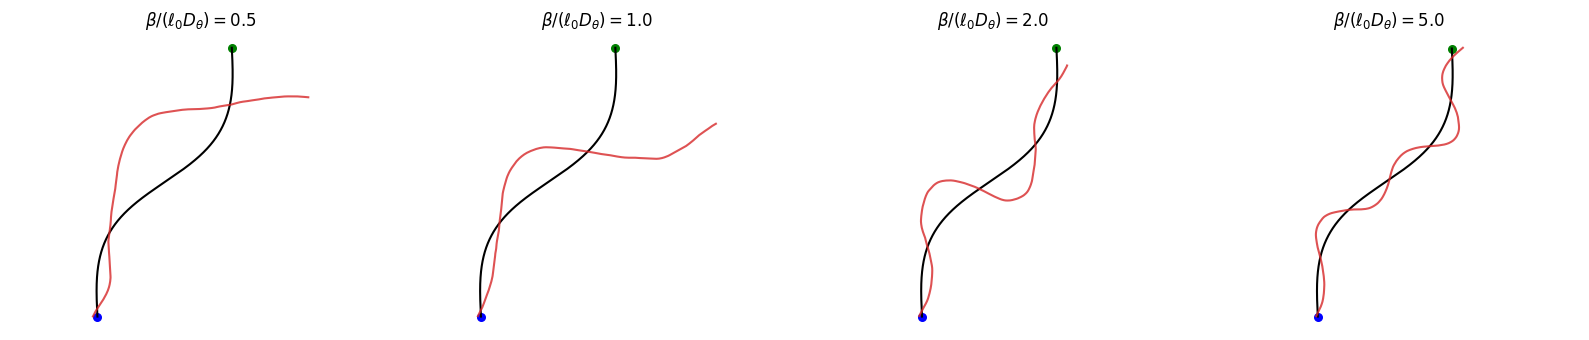

In [ ]:
import matplotlib.pyplot as plt

# === Visualize trajectories for different beta / (l0 Dtheta) values ===
epsilon = 1.0
beta_nom = 1.0  # will scale beta
l0 = float(jnp.linalg.norm(point_b - point_a))
Dtheta_base = 0.1  # fixed base Dtheta
beta_over_l0Dtheta_vals = [0.5, 1.0, 2.0, 5.0]

fig, axs = plt.subplots(1, len(beta_over_l0Dtheta_vals), figsize=(16, 3.5))
trail = create_squiggly_line(point_a, point_b, num_points=num_steps + 1)

for i, val in enumerate(beta_over_l0Dtheta_vals):
    beta = val * l0 * Dtheta_base
    Dtheta = Dtheta_base
    angular_noise_std = (2 * Dtheta / epsilon)**0.5
    key = random.PRNGKey(1000 + i)
    scan_steps = jnp.arange(num_steps)
    traj = simulate_agent(trail, angular_noise_std, beta, key, scan_steps)

    axs[i].plot(trail[:, 0], trail[:, 1], color='black', linewidth=1.5, label="Trail")
    axs[i].plot(traj[:, 0], traj[:, 1], color='tab:red', alpha=0.8, label="Trajectory")
    axs[i].scatter(*point_a, color='blue', s=30)
    axs[i].scatter(*point_b, color='green', s=30)
    axs[i].set_title(rf"$\beta / (\ell_0 D_\theta) = {val}$")
    axs[i].axis("equal")
    axs[i].axis("off")

plt.tight_layout()
plt.savefig("trail_following_trajectories_by_beta_over_l0Dtheta.pdf", dpi=300, bbox_inches='tight')
plt.show()

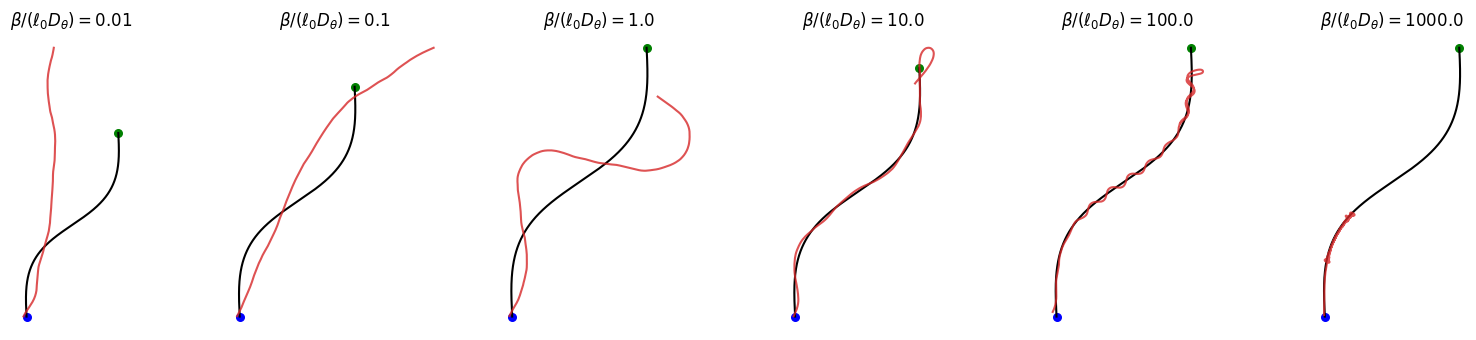

In [ ]:
import matplotlib.pyplot as plt

# === Visualize trajectories for different beta / (l0 Dtheta) values ===
epsilon = 1.0
beta_nom = 1.0  # will scale beta
l0 = float(jnp.linalg.norm(point_b - point_a))
Dtheta_base = 0.1  # fixed base Dtheta
beta_over_l0Dtheta_vals = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
num_steps = 15000

fig, axs = plt.subplots(1, len(beta_over_l0Dtheta_vals), figsize=(16, 3.5))

trail = create_squiggly_line(point_a, point_b, num_points=num_steps + 1)

for i, val in enumerate(beta_over_l0Dtheta_vals):
    beta = val * l0 * Dtheta_base
    Dtheta = Dtheta_base
    angular_noise_std = (2 * Dtheta / epsilon)**0.5
    key = random.PRNGKey(1000 + i)
    scan_steps = jnp.arange(num_steps)
    traj = simulate_agent(trail, angular_noise_std, beta, key, scan_steps)

    ax = axs[i]
    ax.plot(trail[:, 0], trail[:, 1], color='black', linewidth=1.5, label="Trail")
    ax.plot(traj[:, 0], traj[:, 1], color='tab:red', alpha=0.8, label="Trajectory")
    ax.scatter(*point_a, color='blue', s=30)
    ax.scatter(*point_b, color='green', s=30)
    ax.set_title(rf"$\beta / (\ell_0 D_\theta) = {val}$", fontsize=12)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

plt.tight_layout()
plt.savefig("trail_following_trajectories_by_beta_over_l0Dtheta.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
import numpy as np

# === Define constants and trail ===
epsilon = 1.0
beta_nom = 1.0
Dtheta_base = 0.1
l0 = float(jnp.linalg.norm(point_b - point_a))
num_steps = 15000
beta_over_l0Dtheta_vals = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

# === Create trail and grid for pheromone visualization ===
trail = create_squiggly_line(point_a, point_b, num_points=num_steps + 1)

# === Define 2D grid for pheromone field visualization ===
x_range = jnp.linspace(-0.1, 0.6, 200)
y_range = jnp.linspace(-0.1, 1.1, 200)
X, Y = jnp.meshgrid(x_range, y_range)
positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)

# === Compute pheromone field from trail ===
def compute_pheromone_field(positions, trail):
    dx = positions[:, None, 0] - trail[None, :, 0]
    dy = positions[:, None, 1] - trail[None, :, 1]
    distances = dx**2 + dy**2
    field = jnp.sum(jnp.exp(-distances / (2 * sigma_pheromone**2)), axis=1)
    return field

pheromone = compute_pheromone_field(positions, trail)
pheromone_grid = pheromone.reshape(X.shape)
pheromone_clipped = jnp.clip(pheromone_grid, 0.0, jnp.percentile(pheromone_grid, 99))
white_orange = get_cmap('Oranges')
norm = Normalize(vmin=pheromone_clipped.min(), vmax=pheromone_clipped.max())

# === Plot ===
fig, axs = plt.subplots(1, len(beta_over_l0Dtheta_vals), figsize=(16, 3.5))

for i, val in enumerate(beta_over_l0Dtheta_vals):
    beta = val * l0 * Dtheta_base
    Dtheta = Dtheta_base
    angular_noise_std = (2 * Dtheta / epsilon)**0.5
    key = random.PRNGKey(1000 + i)
    scan_steps = jnp.arange(num_steps)
    traj = simulate_agent(trail, angular_noise_std, beta, key, scan_steps)

    ax = axs[i]
    ax.contourf(X, Y, pheromone_clipped, levels=100, cmap=white_orange, norm=norm)
    trail_line, = ax.plot(trail[:, 0], trail[:, 1], color='black', linewidth=1.5)
    traj_line, = ax.plot(traj[:, 0], traj[:, 1], color='tab:red', alpha=0.9)
    ax.scatter(*point_a, color='blue', s=30, zorder=5)
    ax.scatter(*point_b, color='green', s=30, zorder=5)

    ax.set_title(rf"$\beta / (\ell_0 D_\theta) = {val}$", fontsize=12)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

# === Custom legend in the last subplot ===
ax = axs[-1]
legend_elements = [
    mpatches.Patch(color='orange', label='Pheromone field'),
    mlines.Line2D([], [], color='black', label='Trail', linewidth=1.5),
    mlines.Line2D([], [], color='tab:red', label='Trajectory', linewidth=1.5),
    mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=6, label='Source'),
    mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=6, label='Target'),
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10, frameon=True)

plt.tight_layout()
plt.savefig("trail_following_with_legend.pdf", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipython-input-65-1885128075.py:72: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


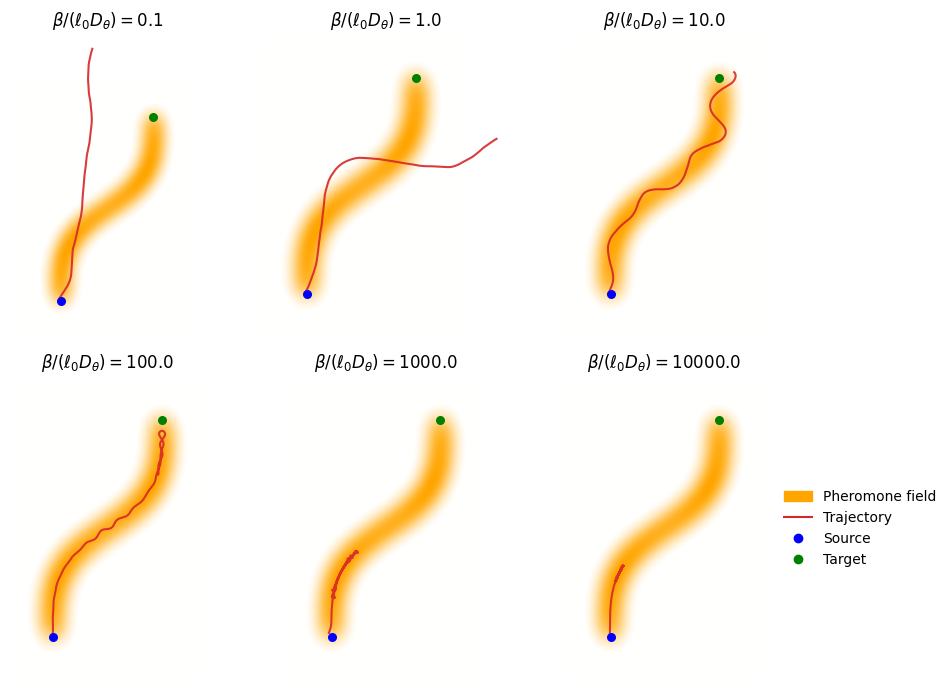

In [ ]:
import matplotlib.colors as mcolors

# Precompute trail and pheromone grid
trail = create_squiggly_line(point_a, point_b, num_points=num_steps + 1)
x_vals = jnp.linspace(-0.2, 0.7, 200)
y_vals = jnp.linspace(-0.2, 1.2, 200)
X, Y = jnp.meshgrid(x_vals, y_vals)

beta_over_l0Dtheta_vals = [0.1, 1.0, 10.0, 100.0, 1000.0, 1e4]

@jax.vmap
def pheromone_at_point(xy):
    dx = xy[0] - trail[:, 0]
    dy = xy[1] - trail[:, 1]
    return jnp.sum(vmap_kernel(dx, dy, sigma_pheromone))

grid_points = jnp.stack([X.ravel(), Y.ravel()], axis=-1)
pheromone_vals = pheromone_at_point(grid_points).reshape(X.shape)
pheromone_norm = pheromone_vals / jnp.max(pheromone_vals)

# Normalize and clip for better contrast
threshold = 0.05
pheromone_clipped = jnp.clip(pheromone_norm, threshold, 1.0)
norm = mcolors.Normalize(vmin=threshold, vmax=1.0)
white_orange = mcolors.LinearSegmentedColormap.from_list('white_orange', ['white', 'orange'])

n_cols = 3
n_rows = int(np.ceil(len(beta_over_l0Dtheta_vals) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 3.5 * n_rows), constrained_layout=True)
axs = axs.flatten()

# fig, axs = plt.subplots(1, len(beta_over_l0Dtheta_vals), figsize=(16, 3.5))

for i, val in enumerate(beta_over_l0Dtheta_vals):
    beta = val * l0 * Dtheta_base
    Dtheta = Dtheta_base
    angular_noise_std = (2 * Dtheta / epsilon)**0.5
    key = random.PRNGKey(1000 + i)
    scan_steps = jnp.arange(num_steps)
    traj = simulate_agent(trail, angular_noise_std, beta, key, scan_steps)

    ax = axs[i]
    ax.contourf(X, Y, pheromone_clipped, levels=100, cmap=white_orange, norm=norm)
    # trail_line, = ax.plot(trail[:, 0], trail[:, 1], color='black', linewidth=1.5)
    traj_line, = ax.plot(traj[:, 0], traj[:, 1], color='tab:red', alpha=0.9)

    ax.scatter(*point_a, color='blue', s=30, zorder=5)
    ax.scatter(*point_b, color='green', s=30, zorder=5)

    ax.set_title(rf"$\beta / (\ell_0 D_\theta) = {val}$", fontsize=12)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

# === Custom legend in the last subplot ===
ax = axs[-1]
legend_elements = [
    mpatches.Patch(color='orange', label='Pheromone field'),
    # mlines.Line2D([], [], color='black', label='Trail', linewidth=1.5),
    mlines.Line2D([], [], color='tab:red', label='Trajectory', linewidth=1.5),
    mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=6, label='Source'),
    mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=6, label='Target'),
]

ax.legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    fontsize=10,
    frameon=False
)

plt.tight_layout()
plt.savefig("trail_following_with_legend.pdf", dpi=300, bbox_inches='tight')
plt.show()

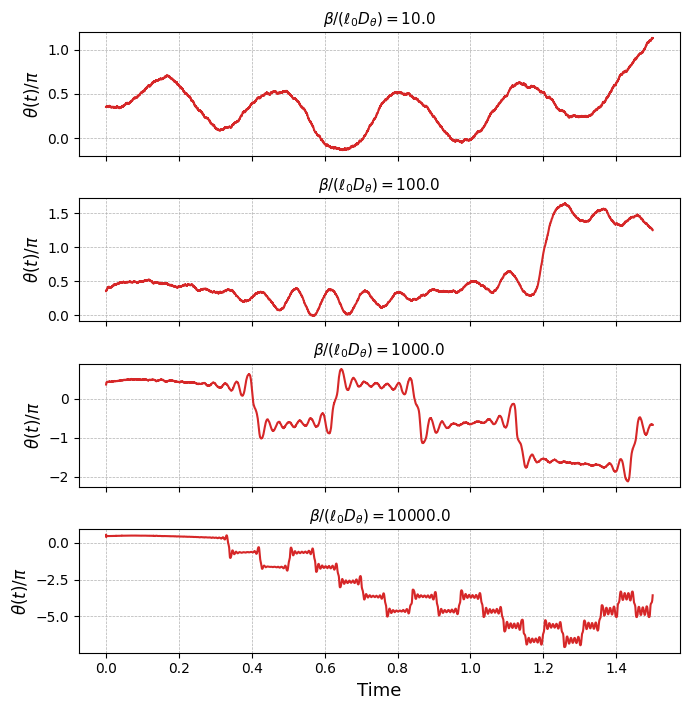

In [ ]:
import numpy as np

def initialize_agent(key):
    key, subkey = random.split(key)
    pos = random.normal(subkey, (2,)) * 0.01
    theta = jnp.arctan2(point_b[1] - point_a[1], point_b[0] - point_a[0])
    return jnp.array([pos[0], pos[1], theta]), key

beta_over_l0Dtheta_vals = [10.0, 100.0, 1e3, 1e4]

# === Theta(t) plots ===
fig, axs = plt.subplots(len(beta_over_l0Dtheta_vals), 1, figsize=(7, 1.8 * len(beta_over_l0Dtheta_vals)), sharex=True)

for i, val in enumerate(beta_over_l0Dtheta_vals):
    beta = val * l0 * Dtheta_base
    angular_noise_std = (2 * Dtheta_base / epsilon)**0.5
    key = random.PRNGKey(1000 + i)

    # === Simulate agent and extract full state ===
    state, key = initialize_agent(key)
    def body(carry, _):
        state, key = carry
        new_state, key = update_agent_state(state, trail, angular_noise_std, beta, key)
        return (new_state, key), new_state
    (_, _), states = jax.lax.scan(body, (state, key), jnp.arange(num_steps))
    theta_vals = jnp.unwrap(states[:, 2])  # Unwrap to avoid angle discontinuities

    t_vals = jnp.linspace(0, num_steps * dt, num_steps)
    axs[i].plot(t_vals, theta_vals/np.pi, color='tab:red')
    axs[i].set_ylabel(r'$\theta(t)/\pi$', fontsize=12)
    axs[i].set_title(rf"$\beta / (\ell_0 D_\theta) = {val}$", fontsize=11)
    axs[i].grid(True, linestyle='--', linewidth=0.5)

axs[-1].set_xlabel("Time", fontsize=13)
plt.tight_layout()
plt.savefig("orientation_over_time_by_beta.pdf", dpi=300, bbox_inches='tight')
plt.show()

# GIFs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from jax import random
import jax.numpy as jnp

# === Simulation setup ===
num_steps = 14000
num_frames = 100
epsilon = 1.0
Dtheta = 0.1
val = 0.1
beta = val * l0 * Dtheta
angular_noise_std = jnp.sqrt(2 * Dtheta / epsilon)
trail = create_squiggly_line(point_a, point_b, num_points=num_steps+1)
key = random.PRNGKey(0)
scan_steps = jnp.arange(num_steps)
traj = simulate_agent(trail, angular_noise_std, beta, key, scan_steps)

# === Subsample 100 equally spaced frames ===
indices = jnp.linspace(0, len(traj) - 1, num_frames).astype(int)
traj_sub = np.array(traj[indices])  # convert to numpy for animation

# === Plot setup ===
fig, ax = plt.subplots(figsize=(5, 5))
fig.suptitle(rf"$\beta / (\ell_0 D_\theta) = {val}$", fontsize=16)
ax.contourf(X, Y, pheromone_clipped, levels=100, cmap=white_orange, norm=norm)
ax.plot(trail[:, 0], trail[:, 1], color='black', linewidth=1.5)
ax.scatter(*point_a, color='blue', s=30, zorder=5)
ax.scatter(*point_b, color='green', s=30, zorder=5)
ax.set_aspect('equal')
ax.axis("off")

# === Artists ===
agent_dot, = ax.plot([], [], 'o', color='tab:red', markersize=5)
path_line, = ax.plot([], [], '-', color='tab:red', linewidth=1.5)
arrow_container = [None]

# === Init function ===
def init():
    agent_dot.set_data([], [])
    path_line.set_data([], [])
    return agent_dot, path_line

# === Update function ===
def update(i):
    x, y = traj_sub[i]
    agent_dot.set_data([x], [y])  # ← fixed here
    path_line.set_data(traj_sub[:i+1, 0], traj_sub[:i+1, 1])

    # Remove old arrow if it exists
    if arrow_container[0] is not None:
        arrow_container[0].remove()

    if i > 0:
        dx, dy = traj_sub[i] - traj_sub[i - 1]
        norm = np.linalg.norm([dx, dy]) + 1e-8
        dx, dy = dx / norm * 0.05, dy / norm * 0.05
        arrow = ax.arrow(x, y, dx, dy, head_width=0.02, color='blue')
        arrow_container[0] = arrow

    return agent_dot, path_line

# === Animate and save ===
ani = animation.FuncAnimation(
    fig, update, frames=num_frames,
    init_func=init, blit=False, interval=50
)

ani.save("agent_trajectory.gif", writer='pillow', fps=20)
plt.close(fig)

# Sequential traversals by agents - homogenous

In [ ]:
def simulate_sequential_agents(num_agents, num_steps, angular_noise_std, key):
    all_trajectories = []
    current_trajectory_points = create_squiggly_line(point_a, point_b)

    for _ in range(num_agents):
        key, subkey = random.split(key)
        trajectory = simulate_agent(current_trajectory_points, num_steps, 10.0, angular_noise_std, subkey)
        all_trajectories.append(trajectory)

        # Update trajectory points for the next agent
        current_trajectory_points = trajectory

    return all_trajectories

In [ ]:
# Multi-agent simulation parameters
num_agents = 50
num_steps = 115

In [ ]:
# Run the multi-agent simulation
key = random.PRNGKey(0)
all_trajectories = simulate_sequential_agents(num_agents, num_steps, angular_noise_std, key)

In [ ]:
def create_pheromone_trail_from_trajectory(trajectory, X, Y, sigma=sigma_pheromone):
    pheromone_field = jnp.zeros_like(X)
    for p in trajectory:
        pheromone_field += gaussian_kernel(X - p[0], Y - p[1], sigma)
    return pheromone_field

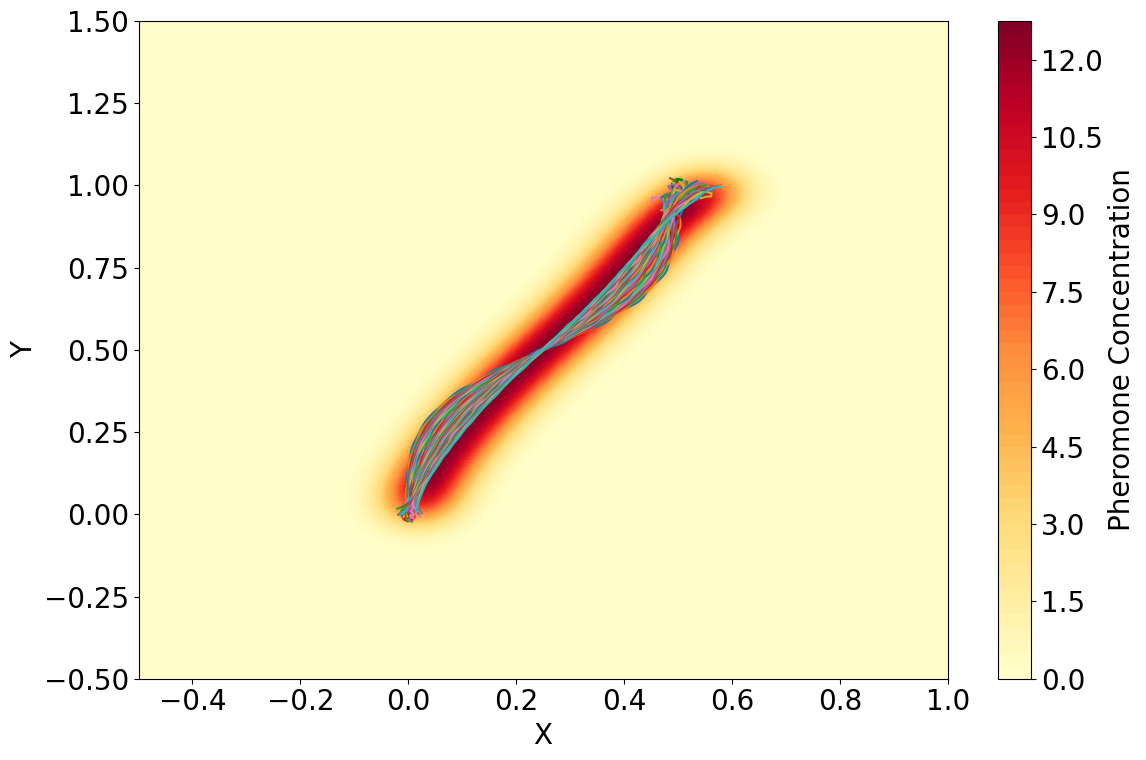

In [ ]:
plt.figure(figsize=(12, 8))
final_pheromone_field = create_pheromone_trail_from_trajectory(all_trajectories[-1], X, Y)
plt.contourf(X, Y, final_pheromone_field, levels=50, cmap='YlOrRd')
plt.colorbar(label='Pheromone Concentration')

for i, trajectory in enumerate(all_trajectories):
    plt.plot(trajectory[:, 0], trajectory[:, 1], label=f'Agent {i+1} Trajectory')

# plt.plot(all_trajectories[-1][:, 0], all_trajectories[-1][:, 1])
plt.scatter(point_a[0], point_a[1], color='red', s=100, label='Source')
plt.scatter(point_b[0], point_b[1], color='green', s=100, label='Target')
# plt.title('Sequential Trail-Following Agents')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('trail_straightening.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import numpy as np

# === Parameters ===
agent_subsample = 7
frames_per_agent = 20
sigma = sigma_pheromone

# === Normalize pheromone field ===
def normalize_pheromone(field):
    return np.clip(field / np.max(field), 0.05, 1.0)

# === Custom colormap ===
white_orange = mcolors.LinearSegmentedColormap.from_list('white_orange', ['white', 'orange'])
norm = mcolors.Normalize(vmin=0.05, vmax=1.0)

# === Prepare figure ===
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_aspect("equal")
ax.axis("off")

# Static markers
ax.scatter(*point_a, color='blue', s=40, zorder=5)
ax.scatter(*point_b, color='green', s=40, zorder=5)

agent_dot, = ax.plot([], [], 'o', color='tab:red', markersize=6)
path_line, = ax.plot([], [], '-', color='tab:red', linewidth=1)
arrow = None

title = ax.text(0.5, 1.05, '', transform=ax.transAxes, ha='center', fontsize=14)

# === Generate frames ===
agent_idxs = list(range(0, len(all_trajectories), agent_subsample))
frames = []
for idx in agent_idxs:
    traj = all_trajectories[idx]
    indices = np.linspace(0, len(traj)-1, frames_per_agent).astype(int)
    for i in indices:
        frames.append((idx, i))

# === Update function ===
def update(frame):
    agent_idx, step = frame
    traj = np.array(all_trajectories[agent_idx])
    pheromone = normalize_pheromone(create_pheromone_trail_from_trajectory(traj, X, Y))

    # Clear axis and redraw everything
    ax.clear()
    ax.set_aspect("equal")
    ax.axis("off")

    # Redraw pheromone field
    ax.contourf(X, Y, pheromone, levels=100, cmap=white_orange, norm=norm)

    # Redraw trail so far
    ax.plot(traj[:step+1, 0], traj[:step+1, 1], color='tab:red')

    # Agent dot and arrow
    x, y = traj[step]
    theta = np.arctan2(traj[step][1] - traj[max(0, step-1)][1],
                       traj[step][0] - traj[max(0, step-1)][0])
    ax.plot(x, y, 'o', color='black')
    ax.arrow(x, y, 0.05 * np.cos(theta), 0.05 * np.sin(theta),
             head_width=0.02, head_length=0.03, fc='black', ec='black')

    # Source and target
    ax.scatter(point_a[0], point_a[1], color='blue', s=60, zorder=5)
    ax.scatter(point_b[0], point_b[1], color='green', s=60, zorder=5)

    # Title
    ax.set_title(f"Agent {agent_idx+1}, Step {step+1}/{traj.shape[0]}", fontsize=12)
    return []

# === Create and save animation ===
ani = animation.FuncAnimation(fig, update, frames=frames, interval=1000 / 15, blit=False)
ani.save("sequential_agents.gif", writer='pillow', fps=15)
plt.close(fig)

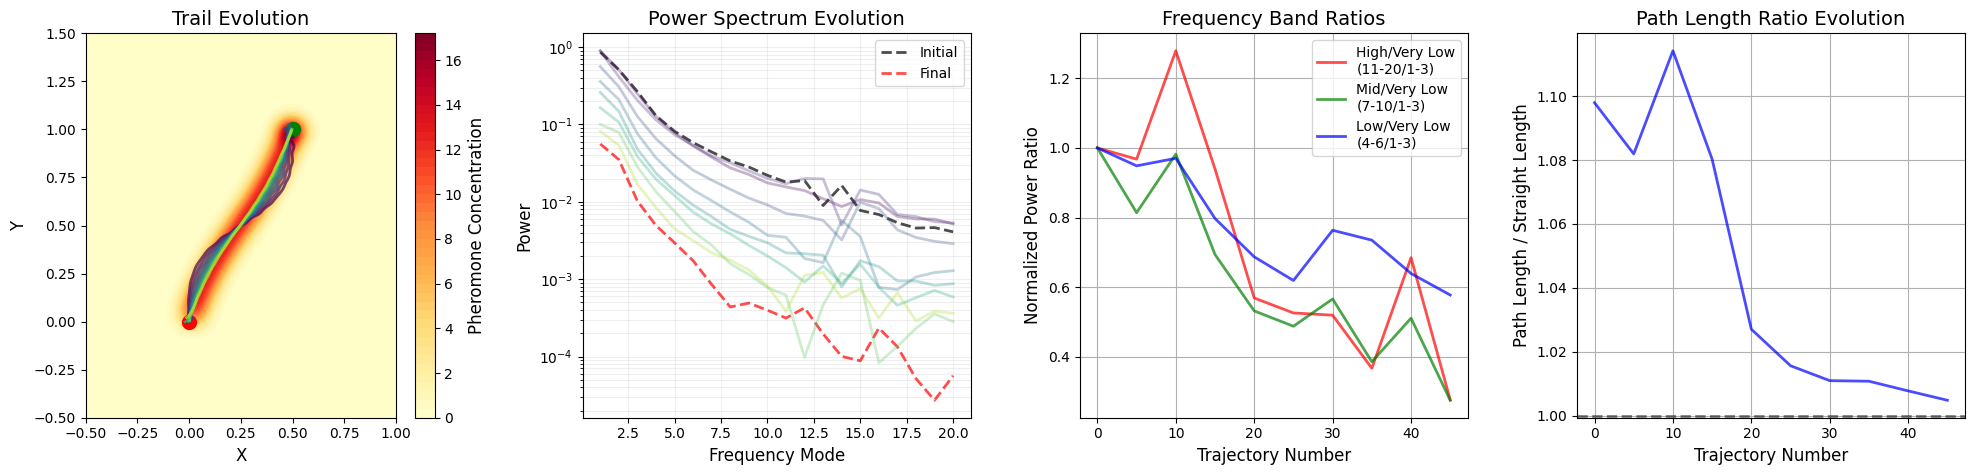


Path Length Statistics:
Initial path ratio: 1.098
Final path ratio: 1.007
Improvement: 8.3%

Frequency Band Ratio Statistics:
Final High/Very Low ratio: 1.090 of initial
Final Mid/Very Low ratio: 0.934 of initial
Final Low/Very Low ratio: 0.986 of initial


In [ ]:
import numpy as np
from scipy.fft import fft
import scipy.signal as signal
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

def analyze_trajectories(trajectories):
    """
    Fourier analysis and path length ratio computation
    """
    n_points = 1024
    power_spectra = []
    deviations_all = []
    path_length_ratios = []

    for traj in trajectories:
        # Compute path length ratio
        path_length = np.sum(np.sqrt(np.diff(traj[:, 0])**2 + np.diff(traj[:, 1])**2))
        straight_length = np.sqrt((traj[-1, 0] - traj[0, 0])**2 +
                                (traj[-1, 1] - traj[0, 1])**2)
        path_length_ratios.append(path_length/straight_length)

        # Fourier analysis
        x = (traj[:, 0] - traj[0, 0]) / (traj[-1, 0] - traj[0, 0])
        y = (traj[:, 1] - traj[0, 1]) / (traj[-1, 1] - traj[0, 1])

        t = np.linspace(0, 1, len(x))

        dx = x - t
        dy = y - t

        normal = np.array([-1, 1]) / np.sqrt(2)
        deviation = dx*normal[0] + dy*normal[1]

        deviations_all.append(deviation)

        t_uniform = np.linspace(0, 1, n_points)
        deviation_uniform = np.interp(t_uniform, t, deviation)
        deviation_detrended = signal.detrend(deviation_uniform)

        spectrum = np.abs(fft(deviation_detrended))**2
        spectrum = spectrum[:n_points//2]
        spectrum = spectrum / len(deviation_detrended)

        power_spectra.append(spectrum)

    return np.array(power_spectra), deviations_all, np.array(path_length_ratios)

def compute_frequency_bands(power_spectra):
    """
    Compute power in different frequency bands:
    - Very low: modes 1-3
    - Low: modes 4-6
    - Mid: modes 7-10
    - High: modes 11-20
    """
    very_low = np.sum(power_spectra[:, 1:4], axis=1)
    low = np.sum(power_spectra[:, 4:7], axis=1)
    mid = np.sum(power_spectra[:, 7:11], axis=1)
    high = np.sum(power_spectra[:, 11:21], axis=1)

    # Compute ratios normalized to initial values
    high_to_vlow = (high/very_low) / (high[0]/very_low[0])
    mid_to_vlow = (mid/very_low) / (mid[0]/very_low[0])
    low_to_vlow = (low/very_low) / (low[0]/very_low[0])

    return high_to_vlow, mid_to_vlow, low_to_vlow

def plot_fourier_analysis(trajectories, final_pheromone_field, stride=5):
    plt.figure(figsize=(20, 5))

    # Plot 1: Selected trajectories
    plt.subplot(141)
    plt.contourf(X, Y, final_pheromone_field, levels=50, cmap='YlOrRd')
    plt.colorbar(label='Pheromone Concentration')

    selected_trajectories = trajectories[::stride]
    for i, trajectory in enumerate(selected_trajectories):
        plt.plot(trajectory[:, 0], trajectory[:, 1],
                color=plt.cm.viridis(i/len(selected_trajectories)),
                alpha=0.7, linewidth=2)

    plt.scatter(point_a[0], point_a[1], color='red', s=100)
    plt.scatter(point_b[0], point_b[1], color='green', s=100)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Trail Evolution')

    # Compute spectra, deviations, and path length ratios
    power_spectra, deviations, path_ratios = analyze_trajectories(trajectories)

    # Plot 2: Power spectra evolution
    plt.subplot(142)
    frequencies = np.arange(1, 21)  # plot first 20 modes
    power_spectra_selected = power_spectra[::stride]

    plt.semilogy(frequencies, power_spectra_selected[0, 1:21],
                 'k--', label='Initial', alpha=0.7, linewidth=2)
    plt.semilogy(frequencies, power_spectra_selected[-1, 1:21],
                 'r--', label='Final', alpha=0.7, linewidth=2)

    for i, spectrum in enumerate(power_spectra_selected[1:-1]):
        plt.semilogy(frequencies, spectrum[1:21],
                    color=plt.cm.viridis(i/(len(power_spectra_selected)-2)),
                    alpha=0.3)

    plt.xlabel('Frequency Mode')
    plt.ylabel('Power')
    plt.title('Power Spectrum Evolution')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)

    # Plot 3: Frequency band ratios
    plt.subplot(143)
    trajectory_indices = np.arange(0, len(trajectories), stride)
    high_to_vlow, mid_to_vlow, low_to_vlow = compute_frequency_bands(power_spectra)

    plt.plot(trajectory_indices, high_to_vlow[::stride],
            'r-', label='High/Very Low\n(11-20/1-3)', alpha=0.7, linewidth=2)
    plt.plot(trajectory_indices, mid_to_vlow[::stride],
            'g-', label='Mid/Very Low\n(7-10/1-3)', alpha=0.7, linewidth=2)
    plt.plot(trajectory_indices, low_to_vlow[::stride],
            'b-', label='Low/Very Low\n(4-6/1-3)', alpha=0.7, linewidth=2)

    plt.xlabel('Trajectory Number')
    plt.ylabel('Normalized Power Ratio')
    plt.title('Frequency Band Ratios')
    plt.grid(True)
    plt.legend()

    # Plot 4: Path length ratio evolution
    plt.subplot(144)
    plt.plot(trajectory_indices, path_ratios[::stride],
            'b-', label='Path Length Ratio', alpha=0.7, linewidth=2)
    plt.axhline(y=1.0, color='k', linestyle='--', alpha=0.5)
    plt.xlabel('Trajectory Number')
    plt.ylabel('Path Length / Straight Length')
    plt.title('Path Length Ratio Evolution')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('trail_optimization_fourier.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

    # Print statistics
    print("\nPath Length Statistics:")
    print(f"Initial path ratio: {path_ratios[0]:.3f}")
    print(f"Final path ratio: {path_ratios[-1]:.3f}")
    print(f"Improvement: {100*(1 - path_ratios[-1]/path_ratios[0]):.1f}%")

    print("\nFrequency Band Ratio Statistics:")
    print(f"Final High/Very Low ratio: {high_to_vlow[-1]:.3f} of initial")
    print(f"Final Mid/Very Low ratio: {mid_to_vlow[-1]:.3f} of initial")
    print(f"Final Low/Very Low ratio: {low_to_vlow[-1]:.3f} of initial")

# Call this after your simulation:
plot_fourier_analysis(all_trajectories, final_pheromone_field, stride=5)

In [ ]:
import numpy as np
from scipy.fft import fft
from scipy.signal import detrend
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.fft import fft
from scipy.signal import savgol_filter, detrend


mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "text.usetex": False,  # ← fix
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.figsize": (15, 4),
    "lines.linewidth": 2
})

# def analyze_trajectories(trajectories):
#     n_points = 1024
#     power_spectra = []
#     deviations_all = []
#     path_length_ratios = []

#     for traj in trajectories:
#         path_length = np.sum(np.sqrt(np.diff(traj[:, 0])**2 + np.diff(traj[:, 1])**2))
#         straight_length = np.linalg.norm(traj[-1] - traj[0])
#         path_length_ratios.append(path_length / straight_length)

#         x = (traj[:, 0] - traj[0, 0]) / (traj[-1, 0] - traj[0, 0])
#         y = (traj[:, 1] - traj[0, 1]) / (traj[-1, 1] - traj[0, 1])
#         t = np.linspace(0, 1, len(x))

#         dx = x - t
#         dy = y - t
#         deviation = (dx - dy) / np.sqrt(2)

#         t_uniform = np.linspace(0, 1, n_points)
#         deviation_uniform = np.interp(t_uniform, t, deviation)
#         deviation_detrended = detrend(deviation_uniform)

#         spectrum = np.abs(fft(deviation_detrended))**2
#         spectrum = spectrum[:n_points // 2] / len(deviation_detrended)
#         power_spectra.append(spectrum)

#     return np.array(power_spectra), deviations_all, np.array(path_length_ratios)


from scipy.fft import fft
from scipy.signal import savgol_filter
import numpy as np
import numpy as np
from scipy.fft import fft
from scipy.interpolate import UnivariateSpline

def compute_curvature_spline(x_spline, y_spline, t):
    """
    Compute curvature using derivatives from smoothed splines.
    """
    dx = x_spline.derivative(1)(t)
    dy = y_spline.derivative(1)(t)
    ddx = x_spline.derivative(2)(t)
    ddy = y_spline.derivative(2)(t)

    numerator = dx * ddy - dy * ddx
    denominator = (dx**2 + dy**2)**1.5 + 1e-8
    return numerator / denominator

def analyze_trajectories(trajectories, n_points=1024, smoothing=1e-3):
    power_spectra = []
    path_length_ratios = []

    for traj in trajectories:
        t_raw = np.linspace(0, 1, len(traj))
        x_raw, y_raw = traj[:, 0], traj[:, 1]

        # === Fit smoothing splines ===
        x_spline = UnivariateSpline(t_raw, x_raw, s=smoothing)
        y_spline = UnivariateSpline(t_raw, y_raw, s=smoothing)

        # === Uniform evaluation points ===
        t_uniform = np.linspace(0, 1, n_points)

        # === Compute curvature from splines ===
        curvature = compute_curvature_spline(x_spline, y_spline, t_uniform)
        curvature_detrended = curvature - np.mean(curvature)

        # === Power spectrum of curvature ===
        spectrum = np.abs(fft(curvature_detrended))**2
        spectrum = spectrum[:n_points // 2] / len(curvature_detrended)
        power_spectra.append(spectrum)

        # === Path length ratio ===
        path_length = np.sum(np.sqrt(np.diff(x_raw)**2 + np.diff(y_raw)**2))
        straight_length = np.linalg.norm(traj[-1] - traj[0])
        path_length_ratios.append(path_length / straight_length)

    return np.array(power_spectra), np.array(path_length_ratios)


def plot_fourier_analysis(trajectories, final_pheromone_field, stride=5):
    fig, axs = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)

    # === Panel 1: Trajectories over pheromone field ===
    ax = axs[0]
    im = ax.contourf(X, Y, final_pheromone_field, levels=50, cmap='YlOrRd')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Pheromone')

    selected_trajectories = trajectories[::stride]
    for i, trajectory in enumerate(selected_trajectories):
        ax.plot(trajectory[:, 0], trajectory[:, 1],
                color=plt.cm.plasma(i / len(selected_trajectories)), alpha=0.7)

    ax.scatter(point_a[0], point_a[1], color='red', s=40, label='Source')
    ax.scatter(point_b[0], point_b[1], color='green', s=40, label='Target')
    ax.set_title(r"Trail Evolution")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend(loc='upper left', frameon=False)

    # === Panel 2: Power Spectrum Evolution ===
    power_spectra, path_ratios = analyze_trajectories(trajectories)
    ax = axs[1]
    freqs = np.arange(1, 21)
    ps_sel = power_spectra[::stride]

    ax.semilogy(freqs, ps_sel[0, 1:21], 'k--', label='Initial')
    ax.semilogy(freqs, ps_sel[-1, 1:21], 'r--', label='Final')

    for i, spec in enumerate(ps_sel[1:-1]):
        ax.semilogy(freqs, spec[1:21],
                    color=plt.cm.viridis(i / (len(ps_sel) - 2)),
                    alpha=0.3)

    ax.set_xlabel("Frequency Mode")
    ax.set_ylabel("Power")
    ax.set_title(r"Spectral Evolution")
    ax.legend(frameon=False)
    ax.grid(True, which="both", ls="--", alpha=0.3)

    # === Panel 3: Path Length Ratio ===
    ax = axs[2]
    idxs = np.arange(0, len(trajectories), stride)
    ax.plot(idxs, path_ratios[::stride], 'b-', label='Path / Straight')

    ax.axhline(1.0, color='k', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel("Trajectory Index")
    ax.set_ylabel("pathlength / end-to-end distance")
    ax.set_title(r"Path Length Efficiency")
    ax.grid(True)
    ax.legend(frameon=False)

    # Save and show
    plt.savefig("trail_fourier_dashboard.pdf", dpi=300)
    plt.show()

    # Summary
    print(f"Initial path ratio: {path_ratios[0]:.3f}")
    print(f"Final path ratio: {path_ratios[-1]:.3f}")
    print(f"Improvement: {100*(1 - path_ratios[-1]/path_ratios[0]):.1f}%")

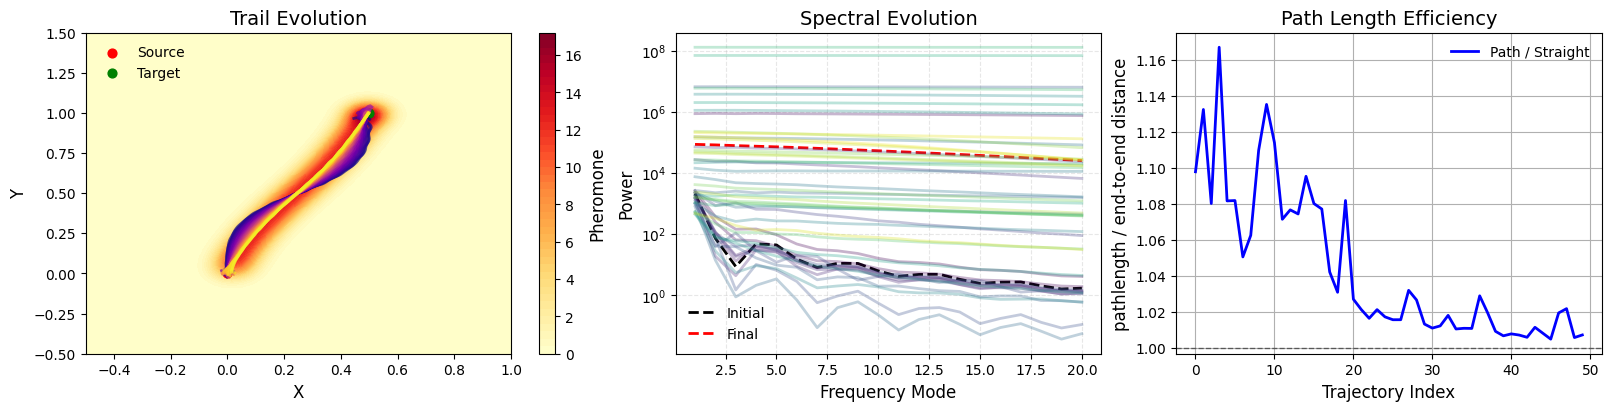

Initial path ratio: 1.098
Final path ratio: 1.007
Improvement: 8.3%


In [ ]:
plot_fourier_analysis(all_trajectories, final_pheromone_field, stride=1)

In [ ]:
def plot_fourier_analysis(trajectories, final_pheromone_field, stride=5):
    import matplotlib.colors as mcolors

    fig, axs = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)

    # === Normalize and threshold pheromone field for white-to-red ===
    pheromone_norm = final_pheromone_field / np.max(final_pheromone_field)
    threshold = 0.05
    pheromone_clipped = np.clip(pheromone_norm, threshold, 0.8)
    norm = mcolors.Normalize(vmin=threshold, vmax=1.0)
    white_to_red = mcolors.LinearSegmentedColormap.from_list('white_red', ['white', 'orange'])

    # === Panel 1: Trajectories over pheromone field ===
    ax = axs[0]
    # im = ax.contourf(X, Y, pheromone_clipped, levels=50, cmap=white_to_red, norm=norm)
    # fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='(Normalized) Pheromone Concentration')

    selected_trajectories = trajectories[::stride]
    for i, trajectory in enumerate(selected_trajectories):
        label = f"Traj {i * stride}"
        ax.plot(trajectory[:, 0], trajectory[:, 1],
                color=plt.cm.plasma(i / len(selected_trajectories)), alpha=0.7, label=label)

    ax.scatter(point_a[0], point_a[1], color='red', s=40, label='Source')
    ax.scatter(point_b[0], point_b[1], color='green', s=40, label='Target')
    ax.set_title(r"Trail Evolution")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend(loc='upper left', fontsize=9, frameon=False)

    # === Panel 2: Power Spectrum Evolution ===
    power_spectra, path_ratios = analyze_trajectories(trajectories)
    ax = axs[1]
    freqs = np.arange(1, 21)
    ps_sel = power_spectra[::stride]

    ax.semilogy(freqs, ps_sel[0, 1:21], 'k--', label='Initial')
    ax.semilogy(freqs, ps_sel[-1, 1:21], 'r--', label='Final')

    for i, spec in enumerate(ps_sel[1:-1]):
        ax.semilogy(freqs, spec[1:21],
                    color=plt.cm.viridis(i / (len(ps_sel) - 2)),
                    alpha=0.3)

    ax.set_xlabel("Frequency Mode")
    ax.set_ylabel("Power")
    ax.set_title(r"Spectral Evolution")
    ax.legend(frameon=False)
    ax.grid(True, which="both", ls="--", alpha=0.3)

    # === Panel 3: Path Length Ratio ===
    ax = axs[2]
    idxs = np.arange(0, len(trajectories), stride)
    ax.plot(idxs, path_ratios[::stride], 'b-', label='Path / Straight')

    ax.axhline(1.0, color='k', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel("Trajectory Index")
    ax.set_ylabel(r'Path / End-to-End Distance')
    ax.set_title(r"Path Length Efficiency")
    ax.grid(True)
    ax.legend(frameon=False)

    # Save and show
    plt.savefig("trail_fourier_dashboard.pdf", dpi=300)
    plt.show()

    # Summary
    print(f"Initial path ratio: {path_ratios[0]:.3f}")
    print(f"Final path ratio: {path_ratios[-1]:.3f}")
    print(f"Improvement: {100*(1 - path_ratios[-1]/path_ratios[0]):.1f}%")

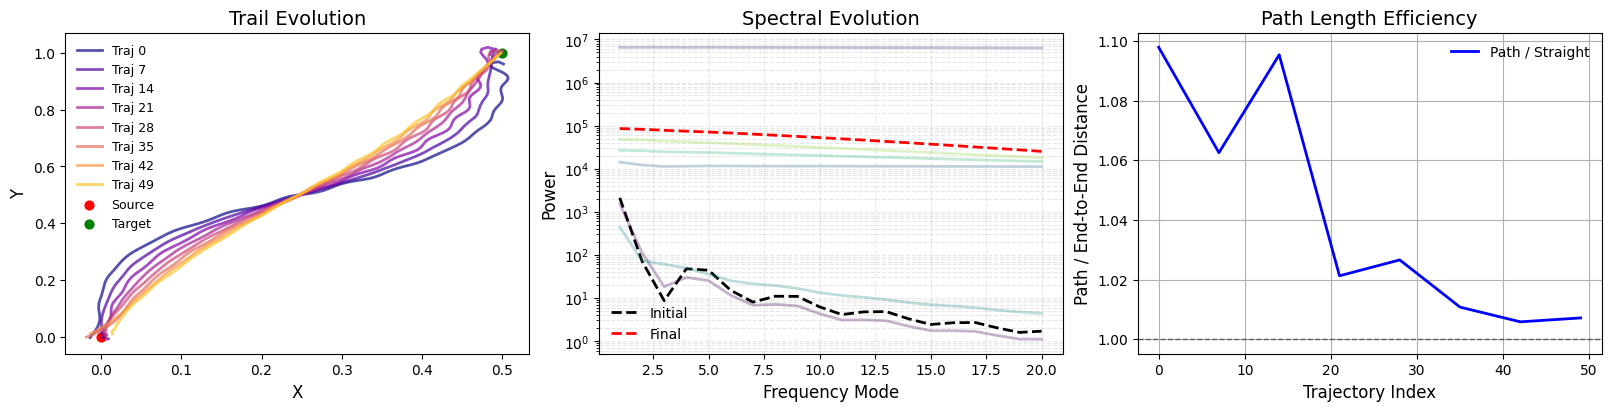

Initial path ratio: 1.098
Final path ratio: 1.007
Improvement: 8.3%


In [ ]:
plot_fourier_analysis(all_trajectories, final_pheromone_field, stride=7)

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import numpy as np

def plot_spline_fit(traj, smoothing=1e-4, n_points=1024, title=None):
    """
    Plot original trajectory and spline-smoothed fit.
    """
    t_raw = np.linspace(0, 0.8, len(traj))
    x_raw, y_raw = traj[:, 0], traj[:, 1]

    # Fit smoothing splines
    x_spline = UnivariateSpline(t_raw, x_raw, s=smoothing)
    y_spline = UnivariateSpline(t_raw, y_raw, s=smoothing)

    # Evaluate smoothed trajectory
    t_fine = np.linspace(0, 1, n_points)
    x_smooth = x_spline(t_fine)
    y_smooth = y_spline(t_fine)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(x_raw, y_raw, 'o-', label='Original', alpha=0.5, markersize=4)
    plt.plot(x_smooth, y_smooth, '-', label='Smoothed Spline', linewidth=2)
    plt.scatter([x_raw[0]], [y_raw[0]], c='green', label='Start', s=50)
    plt.scatter([x_raw[-1]], [y_raw[-1]], c='red', label='End', s=50)

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title or "Spline Fit vs. Original Trajectory")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

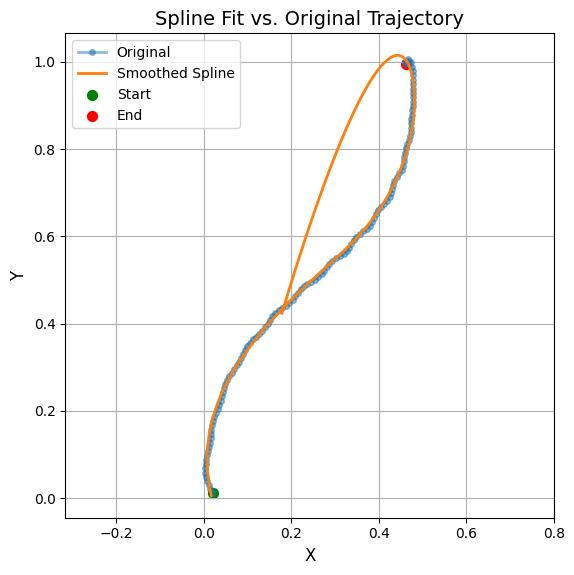

In [ ]:
plot_spline_fit(all_trajectories[10], smoothing=1e-3)

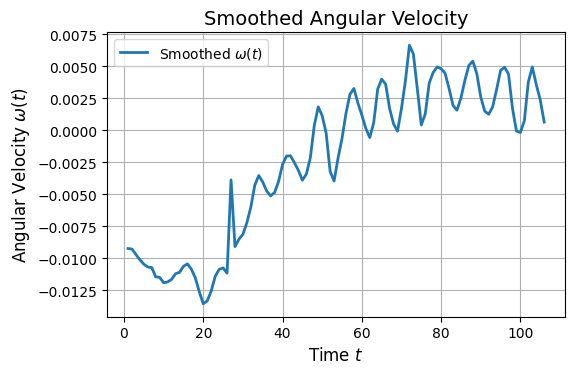

In [ ]:
def extract_valid_trajectory(traj, point_b, tol=0.05):
    dists = np.linalg.norm(traj - point_b, axis=1)
    close_enough = dists < tol
    indices = np.where(close_enough)[0]
    if len(indices) == 0:
        end = len(traj)
    else:
        end = indices[0] + 1  # Include the goal step
    return traj[:end]

def compute_angular_velocity_smoothed(x, y, dt=1.0, smooth_window=5):
    dx = np.diff(x)
    dy = np.diff(y)
    theta = np.arctan2(dy, dx)
    theta_unwrapped = np.unwrap(theta)
    omega = np.diff(theta_unwrapped) / dt

    # Smooth with moving average
    kernel = np.ones(smooth_window) / smooth_window
    omega_smoothed = np.convolve(omega, kernel, mode='same')

    t_omega = np.arange(1, len(theta_unwrapped)) * dt
    return t_omega, omega_smoothed, theta_unwrapped

def plot_angular_velocity(traj, point_b, dt=1.0, smooth_window=5):
    traj_valid = extract_valid_trajectory(traj, point_b)
    x, y = traj_valid[:, 0], traj_valid[:, 1]
    t, omega, _ = compute_angular_velocity_smoothed(x, y, dt, smooth_window)

    plt.figure(figsize=(6, 4))
    plt.plot(t, omega, label=f"Smoothed $\\omega(t)$", color="tab:blue")
    plt.xlabel("Time $t$")
    plt.ylabel("Angular Velocity $\\omega(t)$")
    plt.title("Smoothed Angular Velocity")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_angular_velocity(all_trajectories[-1], point_b, dt=1.0, smooth_window=50)

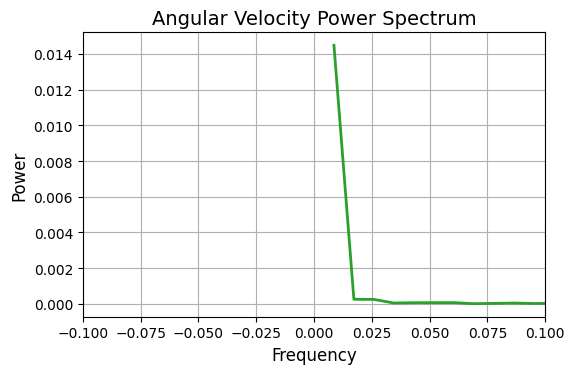

In [ ]:
from scipy.fft import fft, fftfreq

def compute_angular_velocity_spectrum(omega, dt=1.0):
    # Remove DC component (mean)
    omega_zero_mean = omega - np.mean(omega)

    # Compute FFT
    n = len(omega_zero_mean)
    spectrum = np.abs(fft(omega_zero_mean))**2 / n
    freqs = fftfreq(n, dt)

    # Keep only positive frequencies
    mask = freqs > 0
    return freqs[mask], spectrum[mask]


def plot_angular_velocity_spectrum(traj, point_b, dt=1.0, smooth_window=50, freq_range=(0, 0.1)):
    traj_valid = extract_valid_trajectory(traj, point_b)
    x, y = traj_valid[:, 0], traj_valid[:, 1]
    _, omega, _ = compute_angular_velocity_smoothed(x, y, dt, smooth_window)

    freqs, power = compute_angular_velocity_spectrum(omega, dt)

    plt.figure(figsize=(6, 4))
    plt.plot(freqs, power, color="tab:green")
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.title("Angular Velocity Power Spectrum")
    plt.grid(True)
    plt.xlim(*freq_range)  # Apply frequency limit
    plt.tight_layout()
    plt.show()

# Example usage
plot_angular_velocity_spectrum(all_trajectories[0], point_b, dt=1.0, smooth_window=50, freq_range=(-0.1, 0.1))

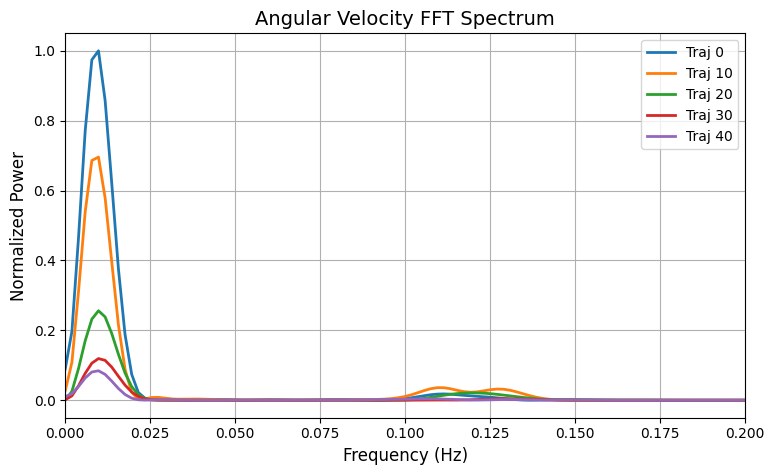

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def extract_valid_trajectory(traj, point_b, tol=0.05):
    dists = np.linalg.norm(traj - point_b, axis=1)
    close_enough = dists < tol
    indices = np.where(close_enough)[0]
    end = indices[0] + 1 if len(indices) > 0 else len(traj)
    return traj[:end]

def compute_angular_velocity_smoothed(x, y, dt=1.0, smooth_window=5):
    dx = np.diff(x)
    dy = np.diff(y)
    theta = np.arctan2(dy, dx)
    theta_unwrapped = np.unwrap(theta)
    omega = np.diff(theta_unwrapped) / dt
    kernel = np.ones(smooth_window) / smooth_window
    omega_smoothed = np.convolve(omega, kernel, mode='same')
    return omega_smoothed

def plot_fft_curves(all_trajectories, point_b, dt=1.0, smooth_window=50, n_fft=512, max_freq=0.5, stride=10):
    plt.figure(figsize=(8, 5))
    freqs = np.fft.fftfreq(n_fft, d=dt)[:n_fft // 2]

    all_powers = []
    labels = []
    for idx in range(0, len(all_trajectories), stride):
        traj = all_trajectories[idx]
        traj_valid = extract_valid_trajectory(traj, point_b)
        x, y = traj_valid[:, 0], traj_valid[:, 1]

        if len(x) < smooth_window + 10:
            continue  # Skip too-short trajectories

        omega = compute_angular_velocity_smoothed(x, y, dt, smooth_window)
        omega -= np.mean(omega)  # Detrend
        omega = omega * np.hanning(len(omega))  # Windowing
        omega_padded = np.pad(omega, (0, max(0, n_fft - len(omega))))
        fft_vals = np.fft.fft(omega_padded, n=n_fft)
        power = np.abs(fft_vals[:n_fft // 2])**2
        all_powers.append(power)
        labels.append(f"Traj {idx}")

    # Normalize all powers by global max
    all_powers = np.array(all_powers)
    if len(all_powers) == 0:
        print("No valid trajectories to plot.")
        return

    max_power = np.max(all_powers)
    all_powers /= max_power

    # Plot
    for i, power in enumerate(all_powers):
        plt.plot(freqs, power, label=labels[i])

    plt.xlim(0, max_freq)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Normalized Power")
    plt.title("Angular Velocity FFT Spectrum")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_fft_curves(all_trajectories, point_b, dt=1.0, smooth_window=50, n_fft=512, max_freq=0.2, stride=10)

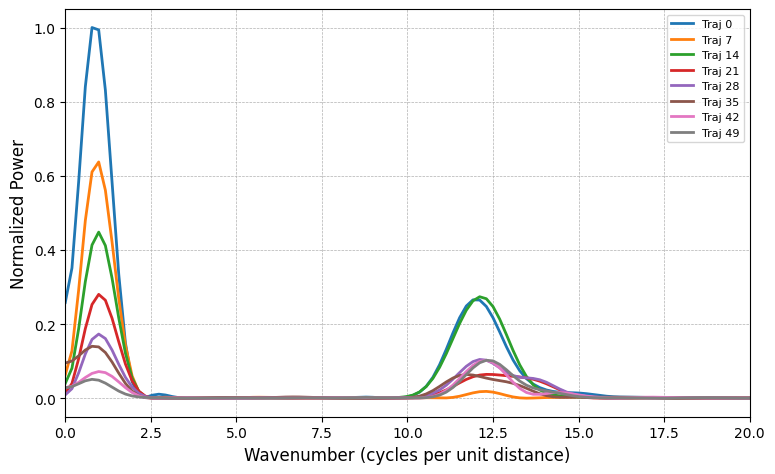

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def extract_valid_trajectory(traj, point_b, tol=0.05):
    dists = np.linalg.norm(traj - point_b, axis=1)
    close_enough = dists < tol
    indices = np.where(close_enough)[0]
    end = indices[0] + 1 if len(indices) > 0 else len(traj)
    return traj[:end]

def compute_curvature_smoothed(x, y, dt=1.0, smooth_window=5):
    dx = np.diff(x)
    dy = np.diff(y)
    theta = np.arctan2(dy, dx)
    theta_unwrapped = np.unwrap(theta)
    omega = np.diff(theta_unwrapped) / dt

    vx = dx[:-1] / dt
    vy = dy[:-1] / dt
    speed = np.sqrt(vx**2 + vy**2)
    speed[speed < 1e-5] = 1e-5

    curvature = omega / speed
    kernel = np.ones(smooth_window) / smooth_window
    curvature_smoothed = np.convolve(curvature, kernel, mode='same')
    return curvature_smoothed

def plot_fft_curves_curvature(all_trajectories, point_b, dt=0.01, smooth_window=50, n_fft=512, max_wavenumber=10.0, stride=10):
    plt.figure(figsize=(8, 5))
    labels = []
    all_powers = []
    all_freqs = None

    for idx in range(0, len(all_trajectories), stride):
        traj = all_trajectories[idx]
        traj_valid = extract_valid_trajectory(traj, point_b)
        x, y = traj_valid[:, 0], traj_valid[:, 1]

        if len(x) < smooth_window + 10:
            continue

        distances = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
        ds = np.mean(distances)

        freqs = np.fft.fftfreq(n_fft, d=ds)[:n_fft // 2]  # Wavenumber
        all_freqs = freqs  # Save for final plotting

        kappa = compute_curvature_smoothed(x, y, dt, smooth_window)
        kappa -= np.mean(kappa)
        kappa *= np.hanning(len(kappa))
        kappa_padded = np.pad(kappa, (0, max(0, n_fft - len(kappa))))
        fft_vals = np.fft.fft(kappa_padded, n=n_fft)
        power = np.abs(fft_vals[:n_fft // 2])**2
        all_powers.append(power)
        labels.append(f"Traj {idx}")

    if not all_powers:
        print("No valid trajectories to plot.")
        return

    all_powers = np.array(all_powers)
    all_powers /= np.max(all_powers)

    for i, power in enumerate(all_powers):
        plt.plot(all_freqs, power, label=labels[i])

    plt.xlim(0, max_wavenumber)
    plt.xlabel("Wavenumber (cycles per unit distance)")
    plt.ylabel("Normalized Power")
    # plt.title("Curvature Spectrum (FFT over Arc Length)")
    plt.legend(fontsize=8)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig('curvature_spectra.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Call the function
plot_fft_curves_curvature(all_trajectories, point_b, dt=0.01, smooth_window=10, n_fft=512, max_wavenumber=20.0, stride=7)

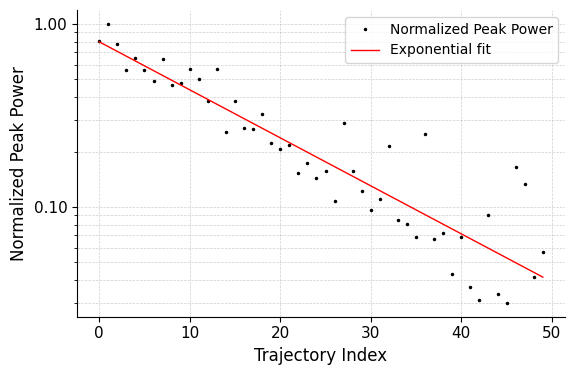

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

def plot_log_peak_power_decay_pretty(all_trajectories, point_b, dt=0.01, smooth_window=50, n_fft=512, stride=10):
    peak_powers = []
    traj_indices = []

    for idx in range(0, len(all_trajectories), stride):
        traj = all_trajectories[idx]
        traj_valid = extract_valid_trajectory(traj, point_b)
        x, y = traj_valid[:, 0], traj_valid[:, 1]

        if len(x) < smooth_window + 10:
            continue

        distances = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
        ds = np.mean(distances)
        kappa = compute_curvature_smoothed(x, y, dt, smooth_window)
        kappa -= np.mean(kappa)
        kappa *= np.hanning(len(kappa))
        kappa_padded = np.pad(kappa, (0, max(0, n_fft - len(kappa))))
        fft_vals = np.fft.fft(kappa_padded, n=n_fft)
        power = np.abs(fft_vals[:n_fft // 2])**2

        peak_powers.append(np.max(power))
        traj_indices.append(idx)

    peak_powers = np.array(peak_powers)
    peak_powers /= np.max(peak_powers)
    traj_indices = np.array(traj_indices)

    # Linear fit in log space
    log_peak = np.log(peak_powers + 1e-10)
    coeffs = np.polyfit(traj_indices, log_peak, deg=1)
    fit_vals = np.exp(np.poly1d(coeffs)(traj_indices))

    # === Plot ===
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(traj_indices, peak_powers, '.', markersize=3, label="Normalized Peak Power", color="black")
    ax.plot(traj_indices, fit_vals, '-', linewidth=1, label=f"Exponential fit", color="red")

    ax.set_xlabel("Trajectory Index", fontsize=12)
    ax.set_ylabel("Normalized Peak Power", fontsize=12)
    # ax.set_title("Decay of Curvature Spectrum Peak Power", fontsize=13)
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)

    ax.legend(fontsize=10)
    ax.tick_params(labelsize=11)
    ax.yaxis.set_major_formatter(ScalarFormatter())  # optional: prevent scientific notation
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig('peak_power.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Run the function
plot_log_peak_power_decay_pretty(all_trajectories, point_b, dt=0.01, smooth_window=50, n_fft=512, stride=1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib import gridspec

def plot_curvature_spectra_with_peak_decay(all_trajectories, point_b,
                                           dt=0.01, smooth_window=50,
                                           n_fft=512, max_wavenumber=10.0,
                                           stride=10, inset_stride=1):

    def extract_valid_trajectory(traj, point_b, tol=0.05):
        dists = np.linalg.norm(traj - point_b, axis=1)
        close_enough = dists < tol
        indices = np.where(close_enough)[0]
        end = indices[0] + 1 if len(indices) > 0 else len(traj)
        return traj[:end]

    def compute_curvature_smoothed(x, y, dt=1.0, smooth_window=5):
        dx = np.diff(x)
        dy = np.diff(y)
        theta = np.arctan2(dy, dx)
        theta_unwrapped = np.unwrap(theta)
        omega = np.diff(theta_unwrapped) / dt

        vx = dx[:-1] / dt
        vy = dy[:-1] / dt
        speed = np.sqrt(vx**2 + vy**2)
        speed[speed < 1e-5] = 1e-5

        curvature = omega / speed
        kernel = np.ones(smooth_window) / smooth_window
        curvature_smoothed = np.convolve(curvature, kernel, mode='same')
        return curvature_smoothed

    # === Prepare full normalized power spectra ===
    all_powers = []
    all_freqs = None
    labels = []
    for idx in range(0, len(all_trajectories), stride):
        traj = extract_valid_trajectory(all_trajectories[idx], point_b)
        x, y = traj[:, 0], traj[:, 1]
        if len(x) < smooth_window + 10:
            continue
        ds = np.mean(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
        freqs = np.fft.fftfreq(n_fft, d=ds)[:n_fft // 2]
        all_freqs = freqs
        kappa = compute_curvature_smoothed(x, y, dt, smooth_window)
        kappa -= np.mean(kappa)
        kappa *= np.hanning(len(kappa))
        kappa_padded = np.pad(kappa, (0, max(0, n_fft - len(kappa))))
        power = np.abs(np.fft.fft(kappa_padded)[:n_fft // 2])**2
        all_powers.append(power)
        labels.append(f"Traj {idx}")
    all_powers = np.array(all_powers)
    all_powers /= np.max(all_powers)

    # === Compute peak power decay ===
    peak_powers = []
    traj_indices = []
    for idx in range(0, len(all_trajectories), inset_stride):
        traj = extract_valid_trajectory(all_trajectories[idx], point_b)
        x, y = traj[:, 0], traj[:, 1]
        if len(x) < smooth_window + 10:
            continue
        ds = np.mean(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
        kappa = compute_curvature_smoothed(x, y, dt, smooth_window)
        kappa -= np.mean(kappa)
        kappa *= np.hanning(len(kappa))
        kappa_padded = np.pad(kappa, (0, max(0, n_fft - len(kappa))))
        fft_vals = np.fft.fft(kappa_padded)
        power = np.abs(fft_vals[:n_fft // 2])**2
        peak_powers.append(np.max(power))
        traj_indices.append(idx)
    peak_powers = np.array(peak_powers)
    peak_powers /= np.max(peak_powers)
    traj_indices = np.array(traj_indices)
    log_peak = np.log(peak_powers + 1e-10)
    coeffs = np.polyfit(traj_indices, log_peak, deg=1)
    fit_vals = np.exp(np.poly1d(coeffs)(traj_indices))

    # === Main Plot ===
    fig, ax = plt.subplots(figsize=(8, 5))
    for i, power in enumerate(all_powers):
        ax.plot(all_freqs, power, label=labels[i], linewidth=1.2)
    ax.set_xlim(0, max_wavenumber)
    ax.set_xlabel("Wavenumber (cycles per unit distance)", fontsize=12)
    # ax.set_ylabel("Normalized Power", fontsize=12)
    ax.set_ylabel(r'Normalized Power: $\tilde{P}^{(n)}(k) = \frac{|\mathcal{F}[\kappa^{(n)}](k)|^2}{\max_{k^\prime,\,n^\prime} |\mathcal{F}[\kappa^{(n^\prime)}](k^\prime)|^2}$', fontsize=12)
    ax.tick_params(labelsize=10)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    ax.legend(fontsize=8, loc='upper right', frameon=False)

    # === Inset ===
    inset_ax = ax.inset_axes([0.45, 0.45, 0.4, 0.4])  # [left, bottom, width, height]
    inset_ax.plot(traj_indices, peak_powers, '.', markersize=3, label="Peak Power", color="black")
    inset_ax.plot(traj_indices, fit_vals, '-', linewidth=1, label="Exponential fit", color="red")
    inset_ax.set_yscale('log')
    inset_ax.set_xlabel("Index", fontsize=9)
    inset_ax.set_ylabel("Peak", fontsize=9)
    inset_ax.tick_params(labelsize=8)
    inset_ax.yaxis.set_major_formatter(ScalarFormatter())
    inset_ax.grid(True, linestyle='--', linewidth=0.4, alpha=0.5)
    inset_ax.spines['top'].set_visible(False)
    inset_ax.spines['right'].set_visible(False)

    # === Save and Show ===
    plt.tight_layout()
    plt.savefig("curvature_spectra_with_inset.pdf", dpi=300, bbox_inches='tight')
    plt.show()

    # Summary print
    print(f"Initial peak: {peak_powers[0]:.3f}")
    print(f"Final peak: {peak_powers[-1]:.3f}")
    print(f"Decay rate: {coeffs[0]:.3f}")

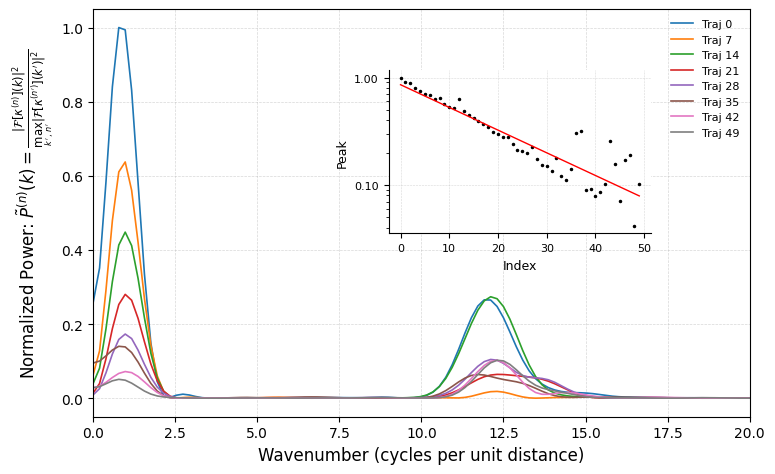

Initial peak: 1.000
Final peak: 0.102
Decay rate: -0.049


In [ ]:
plot_curvature_spectra_with_peak_decay(all_trajectories, point_b,
                                           dt=0.01, smooth_window=10,
                                           n_fft=512, max_wavenumber=20.0,
                                           stride=7, inset_stride=1)

In [ ]:
power_spectra, path_ratios = analyze_trajectories(all_trajectories)

/tmp/ipython-input-115-3812224909.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=10)


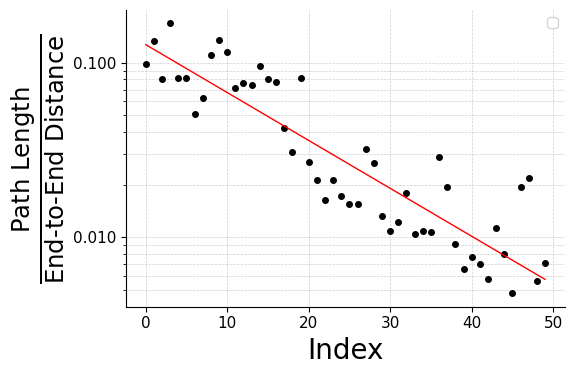

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

def plot_precomputed_log_decay(values, label = r"$\frac{\mathrm{Path\ Length}}{\mathrm{End\text{-}to\text{-}End\ Distance}}$", stride=1):
    traj_indices = np.arange(0, len(values) * stride, stride)
    values = np.array(values)

    # Linear fit in log space
    log_vals = np.log(values + 1e-10)
    coeffs = np.polyfit(traj_indices, log_vals, deg=1)
    fit_vals = np.exp(np.poly1d(coeffs)(traj_indices))

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(traj_indices, values, '.', markersize=8, color="black")
    ax.plot(traj_indices, fit_vals, '-', linewidth=1, color="red")

    ax.set_xlabel("Index", fontsize=20)
    ax.set_ylabel(label, fontsize=25)
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
    ax.legend(fontsize=10)
    ax.tick_params(labelsize=11)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('path_ratio.pdf', dpi=300, bbox_inches='tight')
    plt.show()

plot_precomputed_log_decay(path_ratios-1.0, stride=1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_trajectories_with_inset(trajectories, point_a, point_b, path_ratios, stride=5):
    # === Normalize and clip pheromone for white → red colormap ===
    pheromone_norm = final_pheromone_field / np.max(final_pheromone_field)
    threshold = 0.05
    pheromone_clipped = np.clip(pheromone_norm, threshold, 0.8)
    norm = mcolors.Normalize(vmin=threshold, vmax=1.0)
    white_to_red = mcolors.LinearSegmentedColormap.from_list('white_red', ['white', 'orange'])

    fig, ax = plt.subplots(figsize=(8, 6))

    # === Background pheromone ===
    im = ax.contourf(X, Y, pheromone_clipped, levels=50, cmap=white_to_red, norm=norm)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('(Normalized) Pheromone Concentration')

    # === Plot trajectories ===
    selected_trajectories = trajectories[::stride]
    for i, trajectory in enumerate(selected_trajectories):
        label = f"Traj {i * stride}"
        ax.plot(trajectory[:, 0], trajectory[:, 1],
                color=cm.plasma(i / len(selected_trajectories)),
                alpha=0.7, label=label)

    ax.scatter(point_a[0], point_a[1], color='red', s=60, label='Source')
    ax.scatter(point_b[0], point_b[1], color='green', s=60, label='Target')

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Trail Following Trajectories")
    ax.legend(loc='upper left', fontsize=8, frameon=False)
    ax.grid(True, linestyle='--', alpha=0.4)

    # === Inset plot of path ratios ===
    inset_ax = inset_axes(ax, width="40%", height="40%", loc='lower right', borderpad=2)

    traj_indices = np.arange(0, len(path_ratios) * stride, stride)
    values = np.array(path_ratios)

    # Fit exponential in log space
    log_vals = np.log(values + 1e-10)
    coeffs = np.polyfit(traj_indices, log_vals, deg=1)
    fit_vals = np.exp(np.poly1d(coeffs)(traj_indices))

    inset_ax.plot(traj_indices, values, '.', markersize=3, label="path length / end-to-end distance", color="black")
    inset_ax.plot(traj_indices, fit_vals, '-', linewidth=1, label="Exponential fit", color="red")

    inset_ax.set_yscale('log')
    inset_ax.set_xlabel("Traj Index", fontsize=8)
    inset_ax.set_ylabel("Path Ratio", fontsize=8)
    inset_ax.tick_params(labelsize=8)
    inset_ax.legend(fontsize=7, loc='upper right')
    inset_ax.grid(True, which='both', linestyle='--', linewidth=0.4, alpha=0.5)
    inset_ax.yaxis.set_major_formatter(ScalarFormatter())

    # === Finalize ===
    plt.tight_layout()
    plt.savefig("trajectories_with_inset.pdf", dpi=300, bbox_inches='tight')
    plt.show()

/tmp/ipython-input-101-1973857357.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


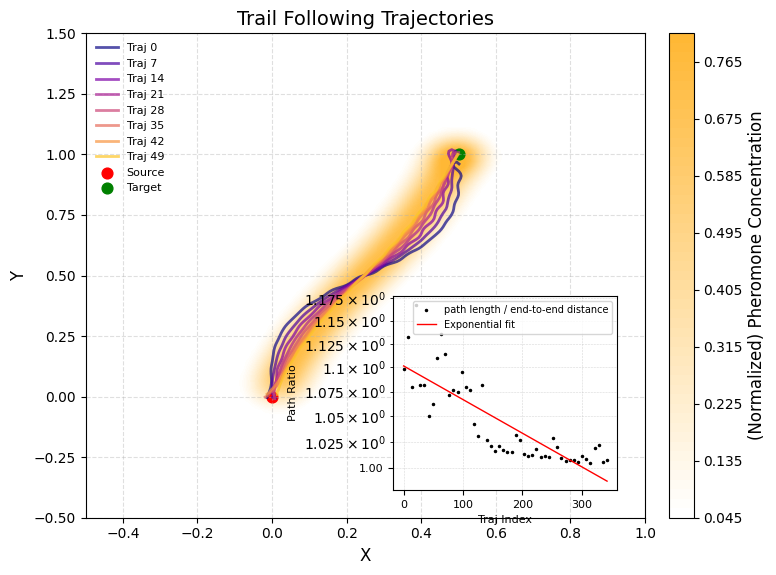

In [ ]:
plot_trajectories_with_inset(all_trajectories, point_a, point_b, path_ratios, stride=7)

# Sequential traversals by agents - inhomogenous

In [ ]:
import time
import jax
import jax.numpy as jnp
from jax import random, lax, grad, vmap
import matplotlib.pyplot as plt

Environment and nu-field

In [ ]:
def sigmoid(x):
    return 1.0 / (1.0 + jnp.exp(-x))

def nu(x, y):
    """
    Example refractive index field that changes with y.
    Agents move with speed = 1 / nu.
    """
    k = 10.0
    return 1.0 + 1.0 * sigmoid(k * (y - 0.5))

def grad_ln_nu(x, y):
    """
    Gradient of ln(nu). nu depends only on y in this example.
    """
    k = 10.0
    s = sigmoid(k * (y - 0.5))
    nu_val = nu(x, y)
    # derivative wrt y
    dnu_dy = 1.0 * k * s * (1.0 - s)
    return jnp.array([0.0, dnu_dy / nu_val])

def create_squiggly_line(point_a, point_b, num_points=120, amplitude=0.0, frequency=0.0):
    """
    Create an initial 'seed' path from point_a to point_b with some sinusoidal noise.
    """
    t = jnp.linspace(0, 1, num_points)
    base_line = point_a + t[:, None] * (point_b - point_a)
    direction = point_b - point_a
    normal = jnp.array([-direction[1], direction[0]])
    normal = normal / jnp.linalg.norm(normal)
    squiggle = amplitude * jnp.sin(frequency * t * 2 * jnp.pi)
    return base_line + squiggle[:, None] * normal

Pheromone

In [ ]:
def gaussian_kernel(dx, dy, sigma):
    return jnp.exp(- (dx**2 + dy**2) / (2.0 * sigma**2))

def compute_weighted_pheromone_gradient(points, weights, x, y, sigma, use_log=True):
    """
    Weighted pheromone gradient:
      sum_j [weights_j * exp(-(dx^2+dy^2)/(2 sigma^2))]
    Then optionally take log(...) and compute grad wrt x,y.
    """
    def eval_pheromone(xx, yy):
        dx = xx - points[:, 0]
        dy = yy - points[:, 1]
        kernel_vals = vmap(lambda ddx, ddy: gaussian_kernel(ddx, ddy, sigma))(dx, dy)
        weighted_sum = jnp.sum(kernel_vals * weights)
        return jnp.log(0.001 + weighted_sum) if use_log else weighted_sum

    gx = grad(lambda xx: eval_pheromone(xx, y))(x)
    gy = grad(lambda yy: eval_pheromone(x, yy))(y)
    return jnp.array([gx, gy])

def create_weighted_pheromone_trail(points, weights, X, Y, sigma):
    """
    For visualization on a grid (X,Y). Weighted sum of Gaussians at each point.
    """
    pheromone_field = jnp.zeros_like(X)
    for (px, py), w in zip(points, weights):
        dx = X - px
        dy = Y - py
        pheromone_field += w * jnp.exp(- (dx**2 + dy**2) / (2.0 * sigma**2))
    return pheromone_field

Agent

In [ ]:
def initialize_agent(key, point_a, point_b, init_noise=0.01):
    """
    Initialize near point_a with a heading pointing from point_a to point_b.
    """
    key, subkey = random.split(key)
    perturb = random.normal(subkey, (2,)) * init_noise
    x0 = point_a[0] + perturb[0]
    y0 = point_a[1] + perturb[1]
    theta0 = jnp.arctan2(point_b[1] - point_a[1], point_b[0] - point_a[0])
    return jnp.array([x0, y0, theta0]), key

def update_agent_state(
    state,
    trajectory_points,
    trajectory_weights,
    sigma,
    dt,
    beta,
    noise_std,
    alpha_lnnu,
    key
):
    """
    Single time-step update using weighted pheromone + gradient(ln(nu)).
    """
    x, y, theta = state

    # Weighted pheromone gradient
    grad_pher = compute_weighted_pheromone_gradient(
        trajectory_points, trajectory_weights, x, y, sigma
    )

    # Refractive index gradient (ln(nu))
    lnnu_g = grad_ln_nu(x, y)

    # Turn is from pheromone gradient + index gradient
    n_hat = jnp.array([-jnp.sin(theta), jnp.cos(theta)])
    turn_from_pher = beta * jnp.dot(grad_pher, n_hat)
    turn_from_nu   = alpha_lnnu * jnp.dot(lnnu_g, n_hat)
    angular_velocity = turn_from_pher + 0.0 * turn_from_nu

    # Noise
    key, subkey = jax.random.split(key)

    # Update heading
    theta_new = theta + nu(x, y) * angular_velocity * dt + noise_std * jnp.sqrt(nu(x, y) * dt) * random.normal(subkey)

    speed = 1
    x_new = x + speed * jnp.cos(theta_new) * dt
    y_new = y + speed * jnp.sin(theta_new) * dt

    return jnp.array([x_new, y_new, theta_new]), key

def simulate_agent(
    trajectory_points,
    trajectory_weights,
    num_steps,
    dt,
    sigma,
    beta,
    noise_std,
    alpha_lnnu,
    key,
    point_a,
    point_b
):
    """
    Simulate one agent, from near point_a to ??? using weighted pheromones.
    """
    state, key = initialize_agent(key, point_a, point_b, init_noise=0.01)

    def body_fn(carry, _):
        st, ky = carry
        new_st, new_ky = update_agent_state(
            st,
            trajectory_points,
            trajectory_weights,
            sigma,
            dt,
            beta,
            noise_std,
            alpha_lnnu,
            ky
        )
        return (new_st, new_ky), new_st[:2]

    (final_state, _), traj = lax.scan(body_fn, (state, key), jnp.arange(num_steps))
    # Include the initial position in the returned path
    return jnp.vstack([state[:2], traj])

def simulate_sequential_agents_weighted(
    num_agents,
    num_steps,
    dt,
    sigma,
    beta,
    noise_std,
    alpha_lnnu,
    key,
    point_a,
    point_b,
    decay=0.9
):
    """
    Launch multiple agents. Each new agent sees all old pheromone points,
    which are decayed by 'decay' each time, so older trails weaken.
    """
    all_trajectories = []

    # "Seed" path so the first agent sees something
    init_path = create_squiggly_line(point_a, point_b)
    all_points = init_path
    all_weights = jnp.ones(shape=(init_path.shape[0],))  # new points have weight=1

    for _ in range(num_agents):
        key, subkey = jax.random.split(key)

        # Each agent sees all_points + their weights
        traj = simulate_agent(
            trajectory_points=all_points,
            trajectory_weights=all_weights,
            num_steps=num_steps,
            dt=dt,
            sigma=sigma,
            beta=beta,
            noise_std=noise_std,
            alpha_lnnu=alpha_lnnu,
            key=subkey,
            point_a=point_a,
            point_b=point_b
        )
        all_trajectories.append(traj)

        # Decay older points
        all_weights = all_weights * decay

        # Add new points at weight=1
        new_weights = jnp.ones(shape=(traj.shape[0],))
        all_points  = jnp.concatenate([all_points,  traj],   axis=0)
        all_weights = jnp.concatenate([all_weights, new_weights], axis=0)

    return all_trajectories, all_points, all_weights

Main

In [ ]:
# Create a grid for final visualization
grid_size = 100
x_grid = jnp.linspace(-0.5, 1.0, grid_size)
y_grid = jnp.linspace(-0.5, 1.5, grid_size)
X, Y = jnp.meshgrid(x_grid, y_grid)

# Define start and end
point_a = jnp.array([0.0, 0.0])
point_b = jnp.array([0.5, 1.0])

# Simulation parameters
dt = 0.01
num_steps = 100
num_agents = 150

# Gains
sigma_pheromone = 0.05
beta = 5.0       # pheromone gradient strength
noise_std = 0.5   # random turning
alpha_lnnu = 5.0  # how strongly we follow grad(ln(nu))
decay = 0.9       # old pheromones weaken by factor 0.9 each new agent

key = random.PRNGKey(int(time.time()))

# Run the simulation
all_trajectories, all_points, all_weights = simulate_sequential_agents_weighted(
    num_agents=num_agents,
    num_steps=num_steps,
    dt=dt,
    sigma=sigma_pheromone,
    beta=beta,
    noise_std=noise_std,
    alpha_lnnu=alpha_lnnu,
    key=key,
    point_a=point_a,
    point_b=point_b,
    decay=decay
)

# Generate a final pheromone field for visualization
final_pheromone_field = create_weighted_pheromone_trail(
    all_points, all_weights, X, Y, sigma_pheromone
)

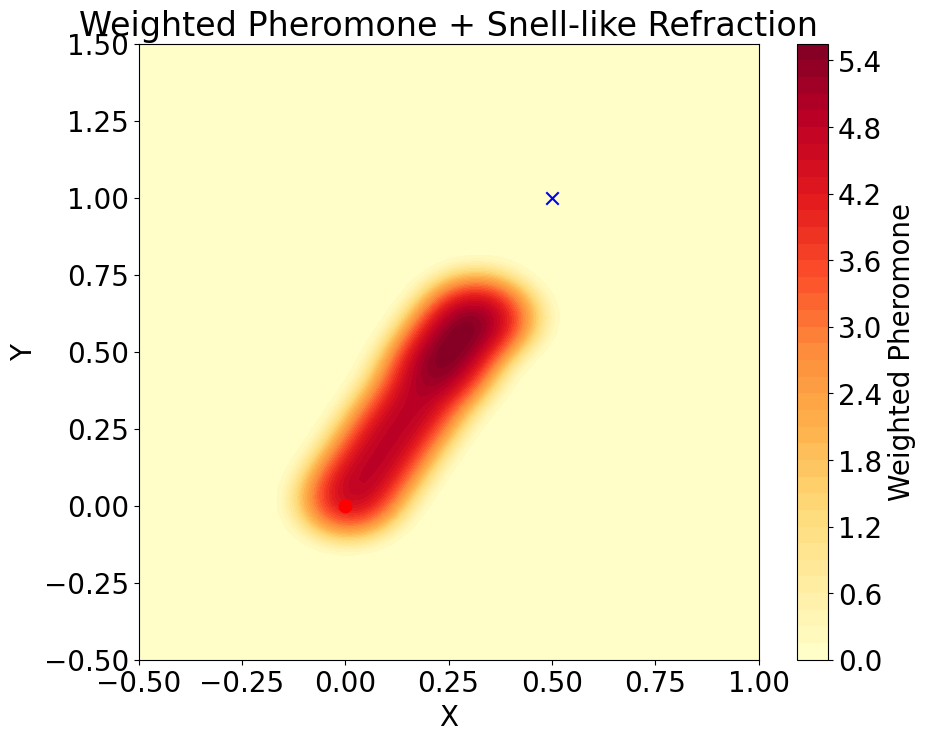

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(10,8))
plt.contourf(X, Y, jnp.log1p(final_pheromone_field), levels=50, cmap='YlOrRd')
plt.colorbar(label="Weighted Pheromone")

# for i, traj in enumerate(all_trajectories):
    # plt.plot(traj[:,0], traj[:,1], label=f"Agent {i+1}")

plt.scatter(point_a[0], point_a[1], color='red', s=80, marker='o', label='Start')
plt.scatter(point_b[0], point_b[1], color='blue', s=80, marker='x', label='End')
plt.title("Weighted Pheromone + Snell-like Refraction")
plt.xlabel("X")
plt.ylabel("Y")
# plt.legend(loc='upper left')
plt.show()

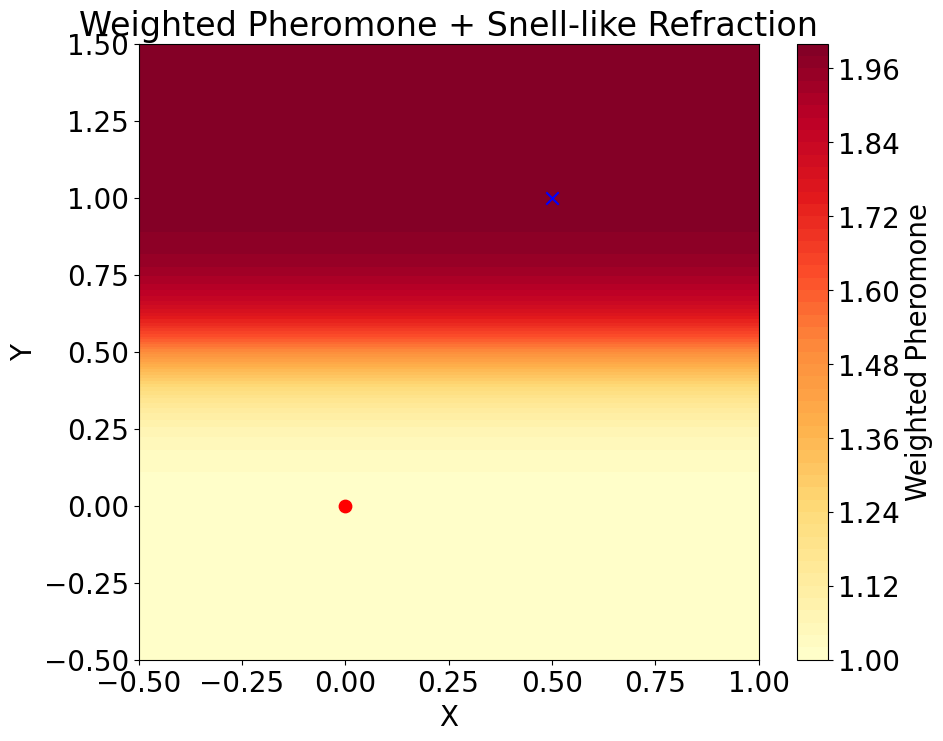

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(10,8))
plt.contourf(X, Y, nu(X,Y), levels=50, cmap='YlOrRd')
plt.colorbar(label="Weighted Pheromone")

# for i, traj in enumerate(all_trajectories):
    # plt.plot(traj[:,0], traj[:,1], label=f"Agent {i+1}")

plt.scatter(point_a[0], point_a[1], color='red', s=80, marker='o', label='Start')
plt.scatter(point_b[0], point_b[1], color='blue', s=80, marker='x', label='End')
plt.title("Weighted Pheromone + Snell-like Refraction")
plt.xlabel("X")
plt.ylabel("Y")
# plt.legend(loc='upper left')
plt.show()

# Optimal control

In [ ]:
import time
import jax
import jax.numpy as jnp
from jax import random, lax, grad, vmap
import matplotlib.pyplot as plt

Environment

In [ ]:
def smooth_piecewise_nu(x, y, base=0.5, jump=1.0, steep=50.0, boundary=0.5):
    """
    A piecewise-smooth refractive index:
      nu = base below y=boundary
      nu = jump above y=boundary
    with a smooth logistic transition of steepness 'steep'.
    """
    # s(y) transitions from 0->1 at y=boundary
    s = 1.0 / (1.0 + jnp.exp(-steep*(y - boundary)))
    return base*(1-s) + jump*s

def grad_ln_nu(x, y):
    """
    Gradient of ln(nu) for smooth_piecewise_nu.
    partial_x ln(nu)=0, partial_y ln(nu)= (1/nu)*partial_y(nu).
    """
    base=0.5; jump=1.0; steep=50.0; boundary=0.5
    nu_val = smooth_piecewise_nu(x, y, base, jump, steep, boundary)
    s = 1.0 / (1.0 + jnp.exp(-steep*(y - boundary)))
    ds_dy = steep*s*(1-s)
    dnu_dy = (jump - base)*ds_dy
    return jnp.array([0.0, dnu_dy/(nu_val + 1e-12)])

def create_seed_path(point_a, point_b, num_points=50, amplitude=0.1):
    """
    A small 'seed' path from A to B with sinusoidal wiggles.
    """
    t = jnp.linspace(0,1,num_points)
    base = point_a + t[:,None]*(point_b - point_a)
    dir_ = point_b - point_a
    normal = jnp.array([-dir_[1], dir_[0]])
    normal /= jnp.linalg.norm(normal)
    wiggle = amplitude * jnp.sin(4.*jnp.pi*t)
    return base + wiggle[:,None]*normal

Pheromone

In [ ]:
def gaussian_kernel(dx, dy, sigma):
    return jnp.exp(- (dx**2 + dy**2)/(2*sigma**2))

def compute_weighted_pheromone_gradient(points, weights, x, y, sigma):
    """
    LOG-based pheromone gradient:
      pheromone_strength = log(0.01 + sum_j [weights_j * Gaussian(...)] )
    Then we do grad wrt x,y.
    """

    def eval_pheromone(xx, yy):
        dx = xx - points[:,0]
        dy = yy - points[:,1]
        vals = vmap(lambda ddx, ddy: gaussian_kernel(ddx, ddy, sigma))(dx, dy)
        total_pher = jnp.sum(vals * weights)
        return jnp.log(0.01 + total_pher)

    gx = grad(lambda xx: eval_pheromone(xx, y))(x)
    gy = grad(lambda yy: eval_pheromone(x, yy))(y)
    return jnp.array([gx, gy])

def create_pheromone_field_for_plot(points, weights, X, Y, sigma, use_log=False):
    """
    Evaluate the pheromone on a grid for visualization.
    """
    shape = X.shape
    def single_point_contrib(px, py, w, Xv, Yv):
        return w * jnp.exp(-((Xv-px)**2 + (Yv-py)**2)/(2*sigma**2))

    pher = jnp.zeros_like(X)
    for (px, py), w in zip(points, weights):
        pher += single_point_contrib(px, py, w, X, Y)
    if use_log:
        pher = jnp.log(0.001 + pher)
    return pher

Agent

In [ ]:
def initialize_agent(key, point_a, point_b, init_noise=0.01):
    """
    Returns (x, y, theta, mu_x, mu_y, gamma).
    We'll set mu=0, gamma=0 as placeholders.
    """
    key, subkey = random.split(key)
    perturb = random.normal(subkey, (2,)) * init_noise
    x0 = point_a[0] + perturb[0]
    y0 = point_a[1] + perturb[1]
    theta0 = jnp.arctan2(point_b[1]-point_a[1], point_b[0]-point_a[0])

    # placeholders for adjoint states
    mu_x0 = 0.0
    mu_y0 = 0.0
    gamma0 = 0.0

    return jnp.array([x0, y0, theta0, mu_x0, mu_y0, gamma0]), key


def update_agent_state(
    state,
    pher_points,
    pher_weights,
    sigma_pher,
    dt,
    beta,
    alpha_nu,
    gamma_goal,
    noise_std,
    key,
    point_b
):
    """
    Single step with placeholders for ADJOINT states.
      state = (x, y, theta, mu_x, mu_y, gamma).
    The old logic updates x,y,theta as before,
    while mu_x, mu_y, gamma are updated with placeholders.
    """
    x, y, theta, mu_x, mu_y, gamma = state

    # ============== Old heading logic (unchanged) ================
    grad_pher = compute_weighted_pheromone_gradient(pher_points, pher_weights, x, y, sigma_pher)
    lnnu_g     = grad_ln_nu(x, y)

    goal_vec = point_b - jnp.array([x, y])
    dist_g   = jnp.linalg.norm(goal_vec) + 1e-12
    goal_hat = goal_vec / dist_g

    n_hat = jnp.array([-jnp.sin(theta), jnp.cos(theta)])

    local_nu  = smooth_piecewise_nu(x, y)

    turn_pher = beta * jnp.dot(grad_pher, n_hat)
    turn_nu   = alpha_nu * jnp.dot(lnnu_g, n_hat)
    turn_goal = gamma_goal * jnp.dot(goal_hat, n_hat)

    angular_vel = turn_pher + turn_nu + turn_goal

    key, subkey = random.split(key)

    theta_new = theta + angular_vel * dt + noise_std * jnp.sqrt(dt) * random.normal(subkey)

    speed     = 1.0 / local_nu

    x_new = x + speed * jnp.cos(theta_new) * dt
    y_new = y + speed * jnp.sin(theta_new) * dt

    # ============== New: ADJOINT placeholders =====================
    # Suppose PDE:
    #    dmu_x/dt = 0, dmu_y/dt=0, dgamma/dt=0, as placeholders
    # You can fill in your partial derivative logic from the paper.

    dmu_x = 0.0
    dmu_y = 0.0
    dgamma= 0.0

    mu_x_new = mu_x + dmu_x * dt
    mu_y_new = mu_y + dmu_y * dt
    gamma_new= gamma + dgamma * dt

    # Return updated
    return jnp.array([x_new, y_new, theta_new, mu_x_new, mu_y_new, gamma_new]), key

def simulate_batch_agents(
    pher_points,
    pher_weights,
    num_steps,
    dt,
    sigma_pher,
    beta,
    alpha_nu,
    gamma_goal,
    noise_std,
    key,
    point_a,
    point_b,
    batch_size
):
    keys = random.split(key, batch_size)

    # vmap over batch dimension
    sim_fn = lambda k: simulate_one_agent(
        pher_points,
        pher_weights,
        num_steps,
        dt,
        sigma_pher,
        beta,
        alpha_nu,
        gamma_goal,
        noise_std,
        k,
        point_a,
        point_b
    )

    batched_trajs = jax.vmap(sim_fn)(keys)  # shape: (B, T, 2)
    return batched_trajs

Multi-agent

In [ ]:
def multi_agent_logpher_batched(
    num_agents=100,
    batch_size=10,
    num_steps=200,
    dt=0.01,
    sigma_pher=0.05,
    beta=5.0,
    alpha_nu=5.0,
    gamma_goal=1.0,
    noise_std=0.2,
    decay=0.95,
    point_a=jnp.array([0.0, 0.0]),
    point_b=jnp.array([0.5, 1.0]),
    key=None
):
    if key is None:
        key = random.PRNGKey(int(time.time()))

    seed = create_seed_path(point_a, point_b, num_points=40, amplitude=0.1)
    all_points = seed
    all_weights = jnp.ones((seed.shape[0],))
    all_trajs = []

    num_batches = num_agents // batch_size
    for _ in range(num_batches):
        key, subkey = random.split(key)
        batch_trajs = simulate_batch_agents(
            all_points,
            all_weights,
            num_steps,
            dt,
            sigma_pher,
            beta,
            alpha_nu,
            gamma_goal,
            noise_std,
            subkey,
            point_a,
            point_b,
            batch_size
        )
        all_trajs.extend(batch_trajs)

        # Update pheromone field
        all_weights = all_weights * decay
        batch_points = batch_trajs.reshape(-1, 2)
        new_weights = jnp.ones((batch_points.shape[0],))
        all_points = jnp.concatenate([all_points, batch_points], axis=0)
        all_weights = jnp.concatenate([all_weights, new_weights], axis=0)

    return all_trajs, all_points, all_weights


Main

In [ ]:
num_agents   = 100
num_steps    = 100
dt           = 0.01
sigma_pher   = 0.01
beta         = 0.0
alpha_nu     = 0.0
gamma_goal   = 10.0
noise_std    = 1.0
decay        = 0.9

point_a = jnp.array([0.0, 0.0])
point_b = jnp.array([0.5, 1.0])

key = random.PRNGKey(int(time.time()))

batch_size = 50  # try 10–50 depending on your GPU
all_trajs, all_points, all_weights = multi_agent_logpher_batched(
    num_agents=num_agents,
    batch_size=batch_size,
    num_steps=num_steps,
    dt=dt,
    sigma_pher=sigma_pher,
    beta=beta,
    alpha_nu=alpha_nu,
    gamma_goal=gamma_goal,
    noise_std=noise_std,
    decay=decay,
    point_a=point_a,
    point_b=point_b,
    key=key
)

Plot

In [ ]:
import plotly.graph_objects as go
import pandas as pd

def plot_simulation_plotly(
    all_trajs,
    all_points,
    all_weights,
    point_a,
    point_b,
    X,
    Y,
    sigma_pher,
    max_agents=20,
    traj_skip=5
):
    """
    Plot pheromone field and agent trajectories using Plotly.
    - max_agents: number of agents to visualize.
    - traj_skip: step stride when plotting trajectories (for speed).
    """
    # --- 1. Compute pheromone field ---
    pher_field = create_pheromone_field_for_plot(all_points, all_weights, X, Y, sigma_pher)
    pher_img = jnp.log1p(pher_field)

    # --- 2. Prepare agent trajectories (subsampled) ---
    traj_data = []
    for agent_id, traj in enumerate(all_trajs[-max_agents:]):
        for step in range(0, traj.shape[0], traj_skip):
            x, y = traj[step]
            traj_data.append({'agent': agent_id, 'step': step, 'x': float(x), 'y': float(y)})

    df = pd.DataFrame(traj_data)

    # --- 3. Create figure ---
    fig = go.Figure()

    # # Add heatmap
    # fig.add_trace(go.Heatmap(
    #     z=pher_img.tolist(),
    #     x=X[0, :].tolist(),
    #     y=Y[:, 0].tolist(),
    #     colorscale='YlOrRd',
    #     showscale=True,
    #     colorbar=dict(title="log(pheromone)")
    # ))

    fig.add_trace(go.Contour(
          z=pher_img.tolist(),
          x=X[0, :].tolist(),
          y=Y[:, 0].tolist(),
          colorscale='YlOrRd',
          showscale=True,
          colorbar=dict(title="log(pheromone)"),
          contours=dict(
              coloring='heatmap',  # Filled, no lines
              showlines=False      # Don't draw contour lines
          ),
          line=dict(width=0)       # Also disables stroke outlines
    ))

    # Add agent trajectories
    for agent_id in df['agent'].unique():
        df_agent = df[df['agent'] == agent_id]
        fig.add_trace(go.Scatter(
            x=df_agent['x'],
            y=df_agent['y'],
            mode='lines',
            name=f'Agent {agent_id}',
            line=dict(width=1),
            opacity=0.7,
            showlegend=False
        ))

    # Add start and goal markers
    fig.add_trace(go.Scatter(
        x=[float(point_a[0])],
        y=[float(point_a[1])],
        mode='markers',
        marker=dict(size=10, color='red'),
        name='Start'
    ))

    fig.add_trace(go.Scatter(
        x=[float(point_b[0])],
        y=[float(point_b[1])],
        mode='markers',
        marker=dict(size=10, color='blue', symbol='x'),
        name='Goal'
    ))

    fig.update_layout(
        title="Pheromone Field and Agent Trajectories",
        xaxis_title="X",
        yaxis_title="Y",
        width=800,
        height=700,
        legend=dict(x=0.01, y=0.99)
    )

    fig.show()


In [ ]:
plot_simulation_plotly(
    all_trajs=all_trajs,
    all_points=all_points,
    all_weights=all_weights,
    point_a=point_a,
    point_b=point_b,
    X=X,
    Y=Y,
    sigma_pher=sigma_pher,
    max_agents=20,
    traj_skip=5          # Every 5th step
)

In [ ]:
# grid_size=100
# xs = jnp.linspace(-0.5,1.0,grid_size)
# ys = jnp.linspace(-0.5,1.5,grid_size)
# X, Y = jnp.meshgrid(xs, ys)

# pher_field = create_pheromone_field_for_plot(all_points, all_weights, X, Y, sigma_pher, use_log=False)

# plt.figure(figsize=(10,8))
# cont = plt.contourf(X, Y, jnp.log1p(pher_field), levels=40, cmap='YlOrRd')
# cbar = plt.colorbar(cont)
# cbar.set_label("Pheromone Concentration")

# # Show last agent's path
# plt.plot(all_trajs[-1][:,0], all_trajs[-1][:,1], 'k-', label="Agent Path")
# plt.scatter(point_a[0], point_a[1], s=80, c='red', label="Start")
# plt.scatter(point_b[0], point_b[1], s=80, c='blue', marker='x', label="Goal")

# # plt.title("Logarithmic Pheromone + Piecewise Refraction + Goal + (mu,gamma) placeholders")
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.legend(loc='upper left')
# plt.tight_layout()
# plt.show()

In [ ]:
# # Assuming jax and matplotlib.pyplot are imported as jnp and plt
# # And smooth_piecewise_nu, grad_ln_nu functions are defined.

# grid_size = 100
# xs = jnp.linspace(-0.5, 1.0, grid_size)
# ys = jnp.linspace(-0.5, 1.5, grid_size)
# X, Y = jnp.meshgrid(xs, ys)

# # Calculate log(nu) values for the background contour plot
# log_nu_field = jnp.log(smooth_piecewise_nu(X, Y))

# # Calculate the gradient of log(nu) at each point
# # We need to vmap grad_ln_nu over the grid points
# # grad_ln_nu returns a [dx, dy] array for a single point
# # So we need to reshape the X, Y grids into a list of points
# points_flat = jnp.stack([X.ravel(), Y.ravel()], axis=-1)

# # Use vmap to apply grad_ln_nu to each point
# # Then reshape back to grid dimensions for U, V components
# grad_flat = jax.vmap(lambda p: grad_ln_nu(p[0], p[1]))(points_flat)
# U = grad_flat[:, 0].reshape(X.shape) # X-component of the gradient
# V = grad_flat[:, 1].reshape(Y.shape) # Y-component of the gradient

# plt.figure(figsize=(10, 8))

# # 1. Plot the contour of log(nu) in the background
# cont = plt.contourf(X, Y, log_nu_field, levels=40, cmap='viridis') # Changed cmap for contrast
# cbar = plt.colorbar(cont)
# cbar.set_label("Log(Refractive Index)")

# # 2. Plot the gradient as a quiver plot (arrows)
# # To avoid too many arrows, we can sample the grid for the quiver plot
# skip = 5 # Plot an arrow every 'skip' points in x and y
# plt.quiver(X[::skip, ::skip], Y[::skip, ::skip], U[::skip, ::skip], V[::skip, ::skip],
#            color='white', scale=50.0, width=0.002) # Adjust scale and width for visibility

# plt.title("Gradient of Log(Refractive Index) Field")
# plt.xlabel("X")
# plt.ylabel("Y")
# # plt.legend(loc='upper left') # No legend needed for this plot
# plt.tight_layout()
# plt.show()

# Plots

In [ ]:
all_trajs = all_trajectories

NameError: name 'all_trajectories' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Ellipse, FancyArrow

# Select every 10th trajectory for visualization
selected_traj_indices = list(range(0, len(all_trajs), 10))
selected_trajs = [all_trajs[i] for i in selected_traj_indices]

# Define figure
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(-0.1, 0.6)
ax.set_ylim(-0.1, 1.1)
# ax.set_title("Agent Motion with Orientation")

# Initialize grid for pheromone field
grid_size = 100
xs = jnp.linspace(-0.5, 1.0, grid_size)
ys = jnp.linspace(-0.5, 1.5, grid_size)
X, Y = jnp.meshgrid(xs, ys)

# Create separate lists to store all points and weights
accumulated_points = []
accumulated_weights = []

# Agent representation
agent = Ellipse((0, 0), width=0.05, height=0.02, edgecolor='black', facecolor='blue', alpha=0.7)
arrow = FancyArrow(0, 0, 0.02, 0, width=0.005, color='black')
ax.add_patch(agent)
ax.add_patch(arrow)

# Trail line
trail, = ax.plot([], [], 'k-', linewidth=1.5, alpha=0.5)

# Start and end points
ax.scatter(0.0, 0.0, color='red', s=80, label='Start')
ax.scatter(0.5, 1.0, color='blue', marker='x', s=80, label='Goal')
ax.legend(loc='upper left')

# Initialize contour plot
contour = ax.contourf(X, Y, np.zeros_like(X), levels=100, cmap="YlOrRd")

def init():
    global accumulated_points, accumulated_weights
    accumulated_points = []
    accumulated_weights = []
    agent.center = (0, 0)
    arrow.set_data(x=0, y=0)
    trail.set_data([], [])
    return agent, arrow, trail

def update(n_frame):
    frame = 10*n_frame
    global accumulated_points, accumulated_weights

    # Calculate which trajectory and step we're on
    traj_idx = frame // len(selected_trajs[0])
    step_idx = frame % len(selected_trajs[0])

    if traj_idx >= len(selected_trajs):
        return agent, arrow, trail

    # Get current trajectory and position
    traj = selected_trajs[traj_idx]
    pos = traj[step_idx]

    # Add current position to accumulated points
    accumulated_points.append(pos)
    accumulated_weights.append(1.0)

    # Clear previous contour
    for coll in ax.collections:
        coll.remove()

    # Update pheromone field with accumulated points
    if accumulated_points:
        pher_field = create_pheromone_field_for_plot(
            jnp.array(accumulated_points),
            jnp.array(accumulated_weights),
            X, Y, 0.05,
            use_log=False
        )
        ax.contourf(X, Y, pher_field, levels=40, cmap="YlOrRd")

    ax.scatter(0.0, 0.0, color='red', s=80, label='Start')
    ax.scatter(0.5, 1.0, color='blue', marker='x', s=80, label='Goal')
    ax.legend(loc='upper left')

    # Calculate orientation
    if step_idx > 0:
        delta = traj[step_idx] - traj[step_idx-1]
        theta = np.arctan2(delta[1], delta[0])
    else:
        theta = 0

    # Update agent position and orientation
    agent.center = pos
    agent.angle = np.degrees(theta)

    # Update arrow
    arrow_length = 0.05
    arrow.set_data(x=pos[0], y=pos[1],
                  dx=arrow_length*np.cos(theta),
                  dy=arrow_length*np.sin(theta))

    # Update trail
    trail.set_data(traj[:step_idx+1, 0], traj[:step_idx+1, 1])

    return agent, arrow, trail

# Create animation
frames = len(selected_trajs) * len(selected_trajs[0])
anim = animation.FuncAnimation(fig, update, frames=int(frames/10),
                             init_func=init, blit=False,
                             interval=50)

# Save animation
writer = animation.PillowWriter(fps=30)
anim.save('ant_simulation.gif', writer=writer)

plt.close()

NameError: name 'all_trajs' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq

def compute_path_efficiency(trajectories, point_a, point_b):
    """
    Compute the ratio of path length to the direct distance between endpoints.
    """
    dist_ab = np.linalg.norm(point_b - point_a)  # Direct distance
    path_lengths = [np.sum(np.linalg.norm(np.diff(traj, axis=0), axis=1)) for traj in trajectories]
    return np.array(path_lengths) / dist_ab  # Ratio of path length to direct distance

num_agents = len(all_trajs)
dt = 0.01  # Time step from simulation
efficiency_ratios = compute_path_efficiency(all_trajs, np.array([0.0, 0.0]), np.array([0.5, 1.0]))

# Plot path efficiency evolution
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_agents + 1), efficiency_ratios, "bo-", markersize=4, alpha=0.7)
plt.xlabel("Trajectory Number")
plt.ylabel("Path Length / Start-Goal Distance")
# plt.title("Path Efficiency Evolution")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_local_curvature(traj, epsilon=1e-6):
    """
    Compute local curvature along a trajectory.
    """
    x, y = traj[:, 0], traj[:, 1]

    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)

    denominator = (dx**2 + dy**2) ** (3/2) + epsilon  # Regularization
    curvatures = np.abs(dx * ddy - dy * ddx) / denominator

    return curvatures

def smooth_data(data, window_size=10):
    """
    Apply a moving average filter to smooth data.
    """
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def plot_curvature_evolution(all_trajs, smooth_window=5, plot_every=10):
    """
    Plot smoothed local curvature for individual trajectories to show
    how curvature decreases with trajectory number.
    """
    plt.figure(figsize=(10, 6))

    num_trajs = len(all_trajs)
    for i in range(0, num_trajs, plot_every):
        curvatures = compute_local_curvature(all_trajs[i])
        smoothed_curvature = smooth_data(curvatures, window_size=smooth_window)
        plt.plot(smoothed_curvature, label=f"Trajectory {i+1}")

    plt.xlabel("Trajectory Step")
    plt.ylabel("Local Curvature")
    # plt.title("Local Curvature Evolution Across Trajectories")
    plt.yscale("log")  # Log scale to highlight trend
    plt.legend()
    plt.grid()
    plt.show()

# Example usage assuming all_trajs is available
plot_curvature_evolution(all_trajs, smooth_window=10, plot_every=10)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_local_curvature(traj, epsilon=1e-6):
    """
    Compute local curvature along a trajectory.
    """
    x, y = traj[:, 0], traj[:, 1]

    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)

    denominator = (dx**2 + dy**2) ** (3/2) + epsilon  # Regularization
    curvatures = np.abs(dx * ddy - dy * ddx) / denominator

    return curvatures

def moving_average(data, window_size=10):
    """
    Apply moving average smoothing to a 1D array.
    """
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def generate_curvature_heatmap(all_trajs, window_size=5):
    """
    Generate a heatmap where:
      - X-axis: Trajectory number (agent iteration)
      - Y-axis: Arc-length (step along trajectory)
      - Color: Local curvature (after smoothing)
    """
    num_trajs = len(all_trajs)
    max_steps = max(len(traj) for traj in all_trajs)

    # Store smoothed curvatures in a 2D array (fill missing values with NaN)
    curvature_matrix = np.full((max_steps, num_trajs), np.nan)

    for i, traj in enumerate(all_trajs):
        curvatures = compute_local_curvature(traj)
        smoothed_curvatures = moving_average(curvatures, window_size=window_size)
        curvature_matrix[:len(smoothed_curvatures), i] = smoothed_curvatures

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    plt.imshow(curvature_matrix, aspect='auto', cmap='YlGnBu', origin='lower',
               extent=[1, num_trajs, 0, max_steps])  # Set proper axis scaling

    plt.colorbar(label="Curvature")
    plt.xlabel("Trajectory Number")
    plt.ylabel("Arc-Length (Trajectory Step)")
    # plt.title(f"Evolution of Local Curvature Across Trajectories (Window={window_size})")
    plt.show()

# Example usage assuming all_trajs is available
generate_curvature_heatmap(all_trajs, window_size=5)


# $\tau$-minimizing curves

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import optax
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
key = jax.random.PRNGKey(0)

# Define the refractive index
# a = 2.0
# b = 1.0

# def nu(x, y):
#     return a * y + b

# # Gradient of log of refractive index
# def grad_ln_nu(x, y):
#     return a / nu(x, y)

def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

def nu(x, y):
    k = 100.0  # Controls the steepness of the sigmoid
    return 1 + sigmoid(k * (y - 0.5))

def grad_ln_nu(x, y):
    k = 100.0  # Should be the same as in nu function
    return k * sigmoid(k * (y - 0.5)) * (1 - sigmoid(k * (y - 0.5))) / nu(x, y)

# Compute curve properties (tangent, normal, curvature)
def curve_properties(params, t):
    # Use neural network to parameterize curve
    x = (0.9 - 0.1) * t + 0.1  # map t from [0,1] to [0.1,0.9]

    # Compute y(t) using a simple neural net
    W1, b1, W2, b2 = params
    h = jnp.tanh(t[:, None] @ W1 + b1)
    y = jnp.squeeze(h @ W2 + b2)

    # Compute derivatives
    dy_dt = jax.vmap(grad(lambda t: curve_y(params, t)))(t)
    d2y_dt2 = jax.vmap(grad(lambda t: grad(lambda t: curve_y(params, t))(t)))(t)

    # Compute geometric properties
    dx_dt = jnp.full_like(dy_dt, 0.8)  # constant due to our x parameterization

    # Tangent vector
    norm = jnp.sqrt(dx_dt**2 + dy_dt**2)
    tx = dx_dt / norm
    ty = dy_dt / norm

    # Normal vector (rotate tangent 90 degrees)
    nx = -ty
    ny = tx

    # Curvature
    kappa = (dx_dt * d2y_dt2 - dy_dt * 0) / (norm**3)

    return x, y, nx, ny, kappa

# Neural network for y(t)
def curve_y(params, t):
    W1, b1, W2, b2 = params
    h = jnp.tanh(t * W1 + b1)
    return jnp.squeeze(h @ W2 + b2)

# Loss function
def loss_fn(params, t):
    x, y, nx, ny, kappa = curve_properties(params, t)

    # Differential equation loss
    diff_eq_loss = jnp.mean((kappa - grad_ln_nu(x,y) * ny)**2)

    # Boundary conditions loss
    bc_loss = (curve_y(params, 0.0) - 0.1)**2 + (curve_y(params, 1.0) - 0.9)**2

    return diff_eq_loss + 10.0 * bc_loss

# Initialize parameters
n_hidden = 32
W1 = jax.random.normal(key, (1, n_hidden)) * 0.1
b1 = jax.random.normal(key, (n_hidden,)) * 0.1
W2 = jax.random.normal(key, (n_hidden, 1)) * 0.1
b2 = jax.random.normal(key, (1,)) * 0.1
params = (W1, b1, W2, b2)

# Optimization
learning_rate = 0.01
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

# Training
@jit
def train_step(params, opt_state, t):
    loss_value, grads = jax.value_and_grad(loss_fn)(params, t)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

# Training loop
n_steps = 100000
t_train = jnp.linspace(0, 1, 100)

for step in range(n_steps):
    params, opt_state, loss = train_step(params, opt_state, t_train)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss}")

# Create figure with larger size
plt.figure(figsize=(12, 8))

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 15

# Create grid for refractive index heatmap
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
nu_grid = nu(x_grid, y_grid)

# Plot refractive index heatmap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

# Define custom colormap from white to light red
colors = [(1, 1, 1), (1, 0.6, 0.6)]  # white to light red
custom_cmap = LinearSegmentedColormap.from_list("white_to_lightred", colors)

# Normalize nu_grid
nu_normalized = (nu_grid - jnp.min(nu_grid)) / (jnp.max(nu_grid) - jnp.min(nu_grid))

# Plot
grid_size = 100
X, Y = jnp.meshgrid(jnp.linspace(0.0, 1.0, grid_size), jnp.linspace(0.0, 1.0, grid_size))
plt.contourf(X, Y, nu_normalized, levels=50, cmap=custom_cmap)
plt.colorbar(label=r'$(\nu - \nu_{\min}) / (\nu_{\max} - \nu_{\min})$')

# Plot the curve
t_plot = jnp.linspace(0, 1, 200)
x_plot = (0.9 - 0.1) * t_plot + 0.1
y_plot = jax.vmap(lambda t: curve_y(params, t))(t_plot)
plt.plot(x_plot, y_plot, 'k-', label=r'$\tau$-minimizing curve', linewidth=2)

# Plot source and target
plt.scatter(0.1, 0.1, c='red', s=100, label='source')
plt.scatter(0.9, 0.9, c='green', s=100, label='destination')

# Labels and layout
plt.xlabel('x')
plt.ylabel('y')
plt.legend(fontsize=18)
plt.xlim(0, 1)
plt.ylim(0, 1)

# Save
plt.savefig('tau-minimizing_curve.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

Step 0, Loss: 2.1390504837036133
Step 100, Loss: 1.9257817268371582
Step 200, Loss: 1.9251519441604614
Step 300, Loss: 1.9249968528747559
Step 400, Loss: 1.9248204231262207
Step 500, Loss: 1.9246253967285156
Step 600, Loss: 1.9244059324264526
Step 700, Loss: 1.9241487979888916
Step 800, Loss: 1.9238280057907104
Step 900, Loss: 1.923403263092041
Step 1000, Loss: 1.9228414297103882
Step 1100, Loss: 1.9221585988998413
Step 1200, Loss: 1.9213957786560059
Step 1300, Loss: 1.9205968379974365
Step 1400, Loss: 1.9198826551437378
Step 1500, Loss: 1.9193789958953857
Step 1600, Loss: 1.9191421270370483
Step 1700, Loss: 1.9190655946731567
Step 1800, Loss: 1.9201411008834839
Step 1900, Loss: 1.919088363647461
Step 2000, Loss: 1.9189077615737915
Step 2100, Loss: 1.918885350227356
Step 2200, Loss: 1.918846845626831
Step 2300, Loss: 1.9188566207885742
Step 2400, Loss: 1.9193145036697388
Step 2500, Loss: 1.9194260835647583
Step 2600, Loss: 1.9194934368133545
Step 2700, Loss: 1.9195585250854492
Step 280

KeyboardInterrupt: 

# References

## Insect navigation
1. *Principles of Insect Path Integration.* S. Heinze, A. Narendra, A. Cheung (2018) \\
https://www.cell.com/current-biology/pdf/S0960-9822(18)30530-X.pdf

## Control and estimation
1. *Optimal control and estimation.* R. F. Stengel (1994)

2. *Model Predictive Control: Theory, Computation, and Design.* Rawlings, Mayne, Diehl (2009) \\
https://sites.engineering.ucsb.edu/~jbraw/mpc/MPC-book-2nd-edition-1st-printing.pdf